In [314]:
import pandas as pd
import numpy as np
from decimal import Decimal
import math

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 

import sklearn
from sklearn import model_selection 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

import scipy
import joblib
import lightgbm as lgbm
import category_encoders as ce
from xgboost import XGBClassifier

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)

pd.options.mode.chained_assignment = None # default='warn'

import warnings
warnings.filterwarnings('ignore')

# 0. Load data

<!-- [data](https://github.com/CapitalOneRecruiting/DS) -->

#### read_json + convert dates: 

transactions.zip compresses a txt file containing json object for each record

In [480]:
df = pd.read_json('transactions.zip', lines=True, convert_dates=['transactionDateTime', \
                'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange'])
df.replace('', np.nan, inplace=True)
df.head(10)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.000,2016-08-13 14:27:32,98.550,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,NaN,0.000,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.000,2016-10-11 05:05:54,74.510,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.000,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.000,2016-11-08 09:18:39,7.470,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.000,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.000,2016-12-10 02:14:50,7.470,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.000,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.000,2016-03-24 21:04:46,71.180,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.000,NaN,NaN,NaN,True,NaN,NaN,False,False
5,830329091,830329091,5000,5000.000,2016-04-19 16:24:27,30.760,In-N-Out #422833,US,US,02,01,fastfood,2020-01-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.000,NaN,NaN,NaN,True,NaN,NaN,False,False
6,830329091,830329091,5000,5000.000,2016-05-21 14:50:35,57.280,Krispy Kreme #685312,US,US,02,01,fastfood,2020-05-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.000,NaN,NaN,NaN,True,NaN,NaN,False,False
7,830329091,830329091,5000,5000.000,2016-06-03 00:31:21,9.370,Shake Shack #968081,US,US,05,01,fastfood,2021-01-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.000,NaN,NaN,NaN,True,NaN,NaN,False,False
8,830329091,830329091,5000,4990.630,2016-06-10 01:21:46,523.670,Burger King #486122,NaN,US,02,01,fastfood,2032-08-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,9.370,NaN,NaN,NaN,True,NaN,NaN,False,False
9,830329091,830329091,5000,5000.000,2016-07-11 10:47:16,164.370,Five Guys #510989,US,US,05,08,fastfood,2020-04-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.000,NaN,NaN,NaN,True,NaN,NaN,False,False


#### load float type as decimal: 

maintain decimal computation accuracy

e.g. Decimal("1.2") - Decimal("1.0") = Decimal('0.2'), but: 1.2-1.0 = 0.19999999999999996

In [481]:
def decimal_from_value(value):
    return round(Decimal(str(value)), 2)

df['creditLimit'] = df['creditLimit'].apply(decimal_from_value)
df['availableMoney'] = df['availableMoney'].apply(decimal_from_value)
df['currentBalance'] = df['currentBalance'].apply(decimal_from_value)
df['transactionAmount'] = df['transactionAmount'].apply(decimal_from_value)

# # now df.loc[2410, 'availableMoney'] == Decimal('4116.64'), but its raw value was 4116.639999999999

In [482]:
print(df.isnull().sum())

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

In [483]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   accountNumber             786363 non-null  int64         
 1   customerId                786363 non-null  int64         
 2   creditLimit               786363 non-null  object        
 3   availableMoney            786363 non-null  object        
 4   transactionDateTime       786363 non-null  datetime64[ns]
 5   transactionAmount         786363 non-null  object        
 6   merchantName              786363 non-null  object        
 7   acqCountry                781801 non-null  object        
 8   merchantCountryCode       785639 non-null  object        
 9   posEntryMode              782309 non-null  object        
 10  posConditionCode          785954 non-null  object        
 11  merchantCategoryCode      786363 non-null  object        
 12  cu

# 1. Understand the raw data

#### Delete all NA columns and rows 

In [484]:
df.dropna(axis=1, how='all', inplace=True)
df.dropna(axis=0, how='all', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786363 entries, 0 to 786362
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   accountNumber             786363 non-null  int64         
 1   customerId                786363 non-null  int64         
 2   creditLimit               786363 non-null  object        
 3   availableMoney            786363 non-null  object        
 4   transactionDateTime       786363 non-null  datetime64[ns]
 5   transactionAmount         786363 non-null  object        
 6   merchantName              786363 non-null  object        
 7   acqCountry                781801 non-null  object        
 8   merchantCountryCode       785639 non-null  object        
 9   posEntryMode              782309 non-null  object        
 10  posConditionCode          785954 non-null  object        
 11  merchantCategoryCode      786363 non-null  object        
 12  cu

In [486]:
# df.to_pickle('data/transactions_pickle')

In [487]:
print('# of data: {}\n# of unique accountID: {}'.format(df.shape[0], df['accountNumber'].nunique()))

# of data: 786363
# of unique accountID: 5000


### Thought:

one account may have more than one transactions.

## Check Data Imbalance

In [448]:
df = pd.read_pickle('data/transactions_pickle')

In [112]:
isFraud = df['isFraud'].value_counts()
class_df = pd.DataFrame({'is_Fraud': isFraud.index, 'Count': isFraud.values})
class_df

,is_Fraud,Count
0,False,773946
1,True,12417


Postive/Negative Ratio: 0.016


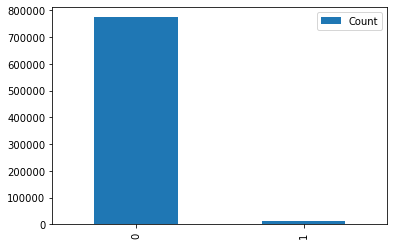

In [113]:
print('Postive/Negative Ratio: {:.3f}'.format(isFraud[1]/isFraud[0]))
class_df.plot.bar()
plt.show()

### Thought:

#### Considering minority class has more than 10k data, it can do down-sampling.

Way to do down-sampling:
1. Split into training and test set first using stratified sampling technique, So **test set keep original imbalanced distribution**
2. Do feature engineering (e.g. summrise feature statistcs in terms of fraud/non-fraud)
3. **Perform down-sampling only on training set before training**


In [25]:
df.describe()

,accountNumber,customerId,cardCVV,enteredCVV,cardLast4Digits
count,786363.000,786363.000,786363.000,786363.000,786363.000
mean,537232599.462,537232599.462,544.467,544.184,4757.418
std,255421092.307,255421092.307,261.524,261.551,2996.584
min,100088067.000,100088067.000,100.000,0.000,0.000
25%,330133277.000,330133277.000,310.000,310.000,2178.000
50%,507456073.000,507456073.000,535.000,535.000,4733.000
75%,767620004.000,767620004.000,785.000,785.000,7338.000
max,999389635.000,999389635.000,998.000,998.000,9998.000


## Check duplicated transaction

In [114]:
df[df.duplicated(keep=False)]

# df.drop_duplicates(subset=None, keep='first', inplace = False).info()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud


## Numerical features

In [115]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df.select_dtypes(include=numerics).columns

Index(['accountNumber', 'customerId', 'cardCVV', 'enteredCVV',
       'cardLast4Digits'],
      dtype='object')

In [116]:
numeric_features = ['creditLimit', 'availableMoney', 'currentBalance', 'transactionAmount'] +\
                    ['cardCVV', 'enteredCVV', 'cardLast4Digits']

## Categorical features

In [117]:
df.select_dtypes(include=['object']).columns

Index(['creditLimit', 'availableMoney', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'currentBalance'],
      dtype='object')

In [118]:
categorical_features = ['merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode',
       'posConditionCode', 'merchantCategoryCode', 'transactionType']

In [119]:
# checking unique values
for col in categorical_features:
    print('{}: {}'.format(col, df[col].nunique()))

merchantName: 2490
acqCountry: 4
merchantCountryCode: 4
posEntryMode: 5
posConditionCode: 3
merchantCategoryCode: 19
transactionType: 3


## Bool features

In [120]:
df.select_dtypes(include=['bool']).columns

Index(['cardPresent', 'expirationDateKeyInMatch', 'isFraud'], dtype='object')

In [121]:
bool_features = ['cardPresent', 'expirationDateKeyInMatch']

## Datetime features

In [122]:
df.select_dtypes(include=['datetime64[ns]']).columns

Index(['transactionDateTime', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange'],
      dtype='object')

In [123]:
datetime_features = ['transactionDateTime', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange']

# 2. Baseline model: Pipeline + GridSearchCV + Feature Importance Visualisation

In [124]:
# remove datetime_features for simplicity
sel_cols = bool_features + numeric_features + categorical_features
# features = df[sel_cols].values
df_sel = df[sel_cols]

In [125]:
df_sel['creditLimit'] = df_sel['creditLimit'].astype(str)

df_sel['availableMoney'] = df_sel['availableMoney'].astype(float)
df_sel['currentBalance'] = df_sel['currentBalance'].astype(float)
df_sel['transactionAmount'] = df_sel['transactionAmount'].astype(float)

In [126]:
df_sel.isnull().sum()

cardPresent                    0
expirationDateKeyInMatch       0
creditLimit                    0
availableMoney                 0
currentBalance                 0
transactionAmount              0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
merchantName                   0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
transactionType              698
dtype: int64

In [127]:
[df_sel.columns.get_loc(col) for col in bool_features]

[0, 1]

In [128]:
numeric_features_idx = [df_sel.columns.get_loc(col) for col in numeric_features]
numeric_features_idx

[2, 3, 4, 5, 6, 7, 8]

In [129]:
[df_sel.columns.get_loc(col) for col in categorical_features]

[9, 10, 11, 12, 13, 14, 15]

In [130]:
train_x, test_x, train_y, test_y = train_test_split(df_sel, df['isFraud'], \
                                                    test_size=0.25, random_state=0, stratify = df['isFraud'])
train_x.head()

,cardPresent,expirationDateKeyInMatch,creditLimit,availableMoney,currentBalance,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType
247233,False,False,5000.0,879.920,4120.080,207.720,869,869,593,Blue Mountain eCards,US,US,02,08,online_gifts,PURCHASE
733168,True,False,2500.0,702.770,1797.230,321.170,350,350,4573,Boston Diner,US,US,02,01,food,PURCHASE
103031,False,False,7500.0,1617.960,5882.040,14.100,406,406,7190,Uber,US,US,09,01,rideshare,PURCHASE
576728,False,False,10000.0,6084.500,3915.500,233.580,470,470,7969,Oklahoma City Post,US,US,05,01,subscriptions,PURCHASE
703102,False,False,7500.0,5682.970,1817.030,369.240,981,981,619,Fresh eCards,US,US,05,08,online_gifts,PURCHASE


In [132]:
def plot_ROC_curve(fpr, tpr):
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest gmeans
    ix = np.argmax(gmeans) # or ix = np.argmax(tpr - fpr), this approach weighs tpr and fpr equally
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    
    plt.legend()
    plt.show()
    
def plot_PR_curve(recall, precision):
    plt.plot([0, 1], [1, 0], 'k--')
    plt.plot(recall, precision, linewidth=2)
    
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve')
    
    plt.legend()
    plt.show()   
    
def df_feature_score(model_name, cols, scores):
    df_ = pd.DataFrame(np.transpose(abs(scores)), columns=["Score"], index=cols)
    df_.sort_values("Score", ascending=True, inplace=True)
    
    plt.figure(figsize=(16,8))
    df_[-30:]['Score'].plot(kind="barh")
    plt.title("Top 30 Important Features  of "+model_name)
    plt.show()

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the True Positive Rate and the specificity (1 - False Positive Rate) (true negative/all real negative).

True Positive Rate (recall) = how many positive samples has been correctly classified among all real positive samples

False Positive Rate = how many negative samples has been misclassified among all real negative samples

G-Mean = sqrt(Sensitivity * Specificity)

```
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
```

PR curve is more suitable for imbalanced data. 

The reason is that typically the large number of class 0 samples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives. Precision and recall do not make use of the true negatives. It is only concerned with the correct prediction of the minority class, class 1.

## Grid Search + Cross Validation

In [133]:
def GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, model_param_grid, score = 'recall'):
    result = {}
    
    gridsearch = GridSearchCV(estimator = pipeline, param_grid = model_param_grid, scoring = score, cv=5)
    
    # find best parameters for each model
    model = gridsearch.fit(train_x, train_y)
    print("best_params :", model.best_params_)  
    result['best_model'] = model.best_estimator_
    y_prob = gridsearch.predict_proba(test_x)[:,1]
    
    fpr, tpr, thresholds = roc_curve(test_y, y_prob)
    plot_ROC_curve(fpr, tpr)
    result['roc_auc'] = roc_auc_score(test_y, y_prob)

    precisions, recalls, _ = precision_recall_curve(test_y, y_prob) 
    plot_PR_curve(precisions, recalls)
    result['pr_auc'] =  auc(recalls, precisions)

    ix = np.argmax(tpr - fpr) # this approach weighs recall and fpr equally
    print('Best threshold: ', thresholds[ix])

    y_pred = (y_prob >= thresholds[ix]).astype(int)

    result['accuracy'] = accuracy_score(test_y, y_pred)
    result['recall'] = recall_score(test_y, y_pred)
    result['precision'] = precision_score(test_y, y_pred)
    result['fscore'] = (2 * result['precision'] * result['recall']) / (result['precision'] + result['recall'])

    cm = confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    
    return result

Penalized Models

Penalized classification imposes an additional cost on the model for making classification mistakes on the minority class during training. These penalties can bias the model to pay more attention to the minority class.

Using penalization is desirable if you are locked into a specific algorithm and are unable to resample or you’re getting poor results. It provides yet another way to “balance” the classes. 

Setting up the penalty matrix can be complex. You will very likely have to try a variety of penalty schemes and see what works best for your problem.

best_params : {'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}


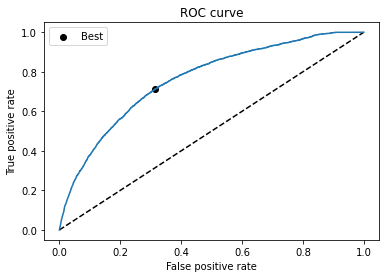

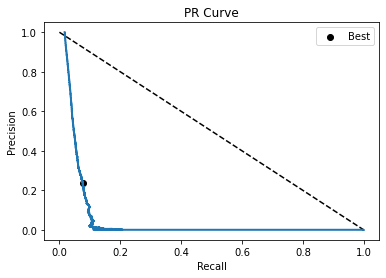

Best threshold:  0.517210705582888
        pred_0  pred_1
true_0  132684   60803
true_1     889    2215
{'best_model': Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('bool',
                                                  Pipeline(steps=[('bool',
                                                                   OrdinalEncoder())]),
                                                  [0, 1]),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 5, 6, 7, 8]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                            

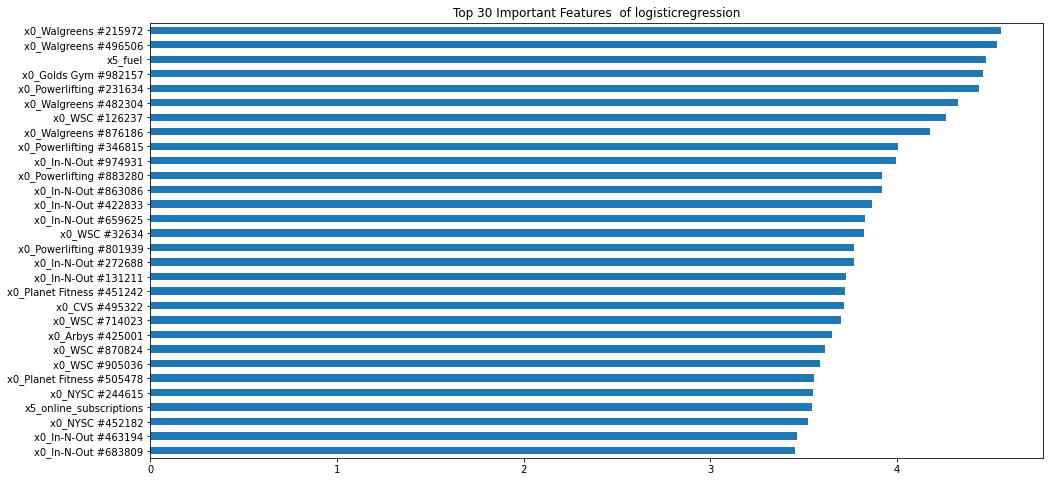

best_params : {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 55}


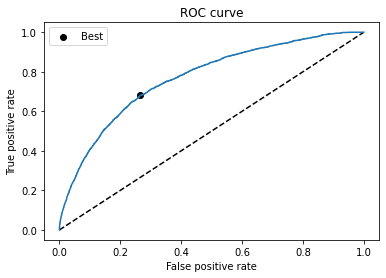

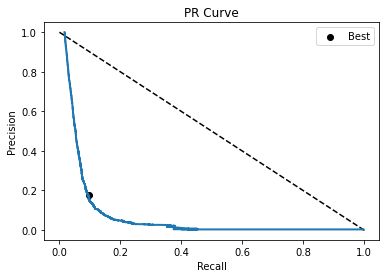

Best threshold:  0.5008596344042934
        pred_0  pred_1
true_0  141994   51493
true_1     989    2115
{'best_model': Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('bool',
                                                  Pipeline(steps=[('bool',
                                                                   OrdinalEncoder())]),
                                                  [0, 1]),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 5, 6, 7, 8]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                           

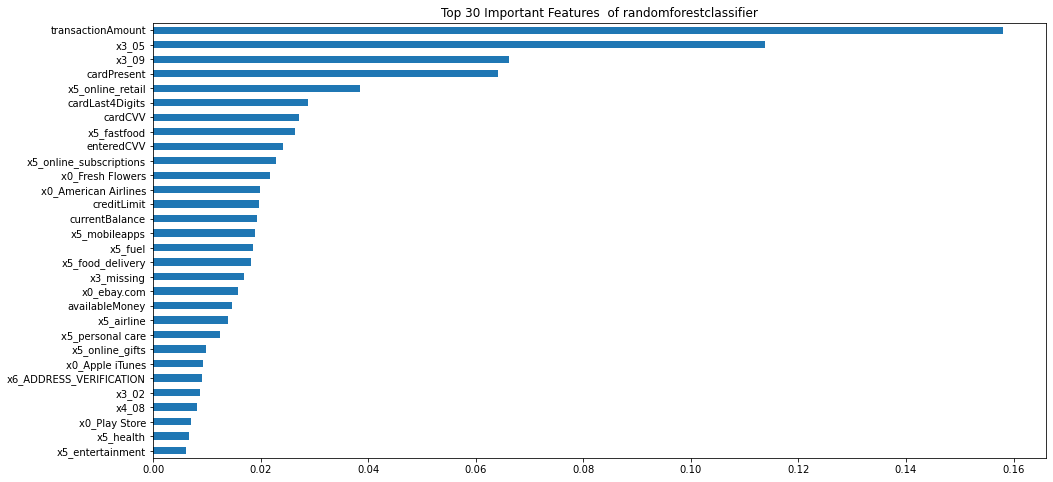

best_params : {'lgbmclassifier__class_weight': 'balanced', 'lgbmclassifier__max_depth': 30, 'lgbmclassifier__n_estimators': 55}


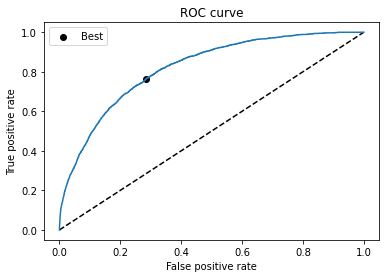

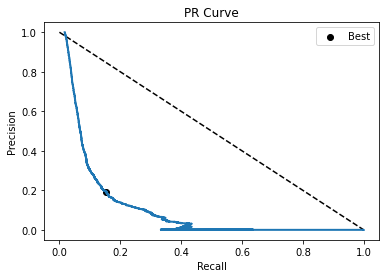

Best threshold:  0.44008329163744686
        pred_0  pred_1
true_0  131772   61715
true_1     622    2482
{'best_model': Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('bool',
                                                  Pipeline(steps=[('bool',
                                                                   OrdinalEncoder())]),
                                                  [0, 1]),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 5, 6, 7, 8]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                          

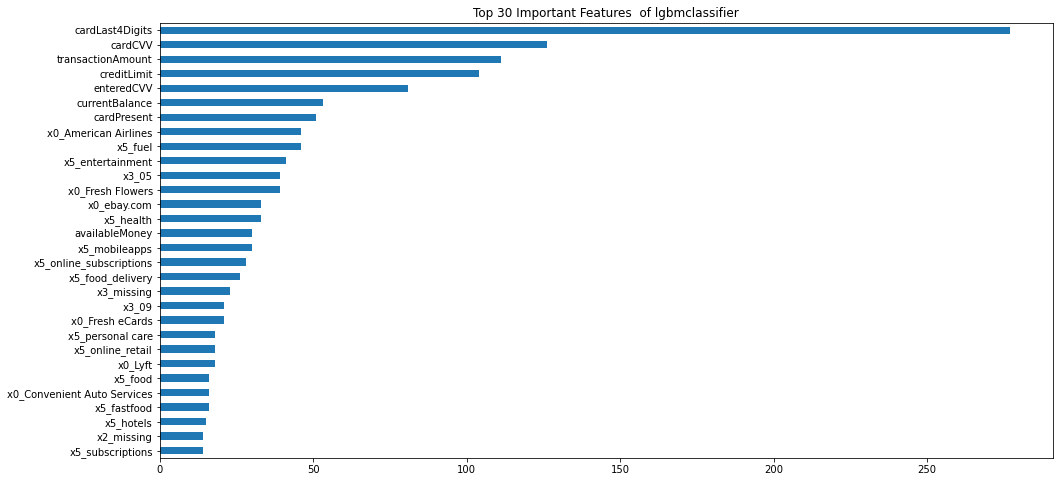

In [134]:
classifiers = [
    LogisticRegression(max_iter=10000),
    RandomForestClassifier(random_state=2021),
    LGBMClassifier(random_state=2021)

]

classifier_names = [
    'logisticregression', 'randomforestclassifier', 'lgbmclassifier'
]

classifier_param_grid = [
            {'logisticregression__penalty':['l2'], 'logisticregression__class_weight':[None, 'balanced']},
            {'randomforestclassifier__n_estimators': [55], 'randomforestclassifier__max_depth':[10, 15, 30], 'randomforestclassifier__class_weight':[None, 'balanced']},
            {'lgbmclassifier__n_estimators': [55], 'lgbmclassifier__max_depth':[10, 15, 30], 'lgbmclassifier__class_weight':[None, 'balanced']}
]

for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    bool_transformer = Pipeline(steps = [
            ('bool', OrdinalEncoder())
    ])
    numeric_transformer = Pipeline(steps = [
            ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps = [
            ("imputer", SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ])
    ct = ColumnTransformer(transformers = [
        # (name, transformer, positional columns or column name)
        ("bool", bool_transformer, [df_sel.columns.get_loc(col) for col in bool_features]),
        ("num", numeric_transformer, [df_sel.columns.get_loc(col) for col in numeric_features]),
        ("cat", categorical_transformer,[df_sel.columns.get_loc(col) for col in categorical_features])
    ])
    pipeline = Pipeline([          
            ('ct', ct),
            (model_name, model)
    ])
    
    result = GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, model_param_grid, score = 'recall')
    
    scores = result['best_model'].named_steps[model_name].coef_ if model_name == 'logisticregression' else result['best_model'].named_steps[model_name].feature_importances_
    
    print(result)
    
    trans_cols = list(bool_features) + list(numeric_features) + \
            list(result['best_model'].named_steps['ct'].transformers_[2][1]['onehot'].get_feature_names())
    df_feature_score(model_name, trans_cols, scores)
    
    print("========================")

### Baseline Performance Summary:

| Model                            | Recall   | Precision | F1 Score  |
| -------------------------------- | -------- | --------- | --------- |
| Weighted Logistic Regression     | 0.714    | 0.035     | 0.067     |
| Random Forest                    | 0.681    | 0.039     | 0.075     |
| LightGBM                         | 0.799    | 0.038     | 0.074     |

Random Forest is the best for having best F1 score, meaning it balance Recall and Precision better than other models.

LightGBM demonstrated the best Recall, but relatively lower Precision than Random Forest.

# 3. Further Data Exploration

## Checking the numerical features

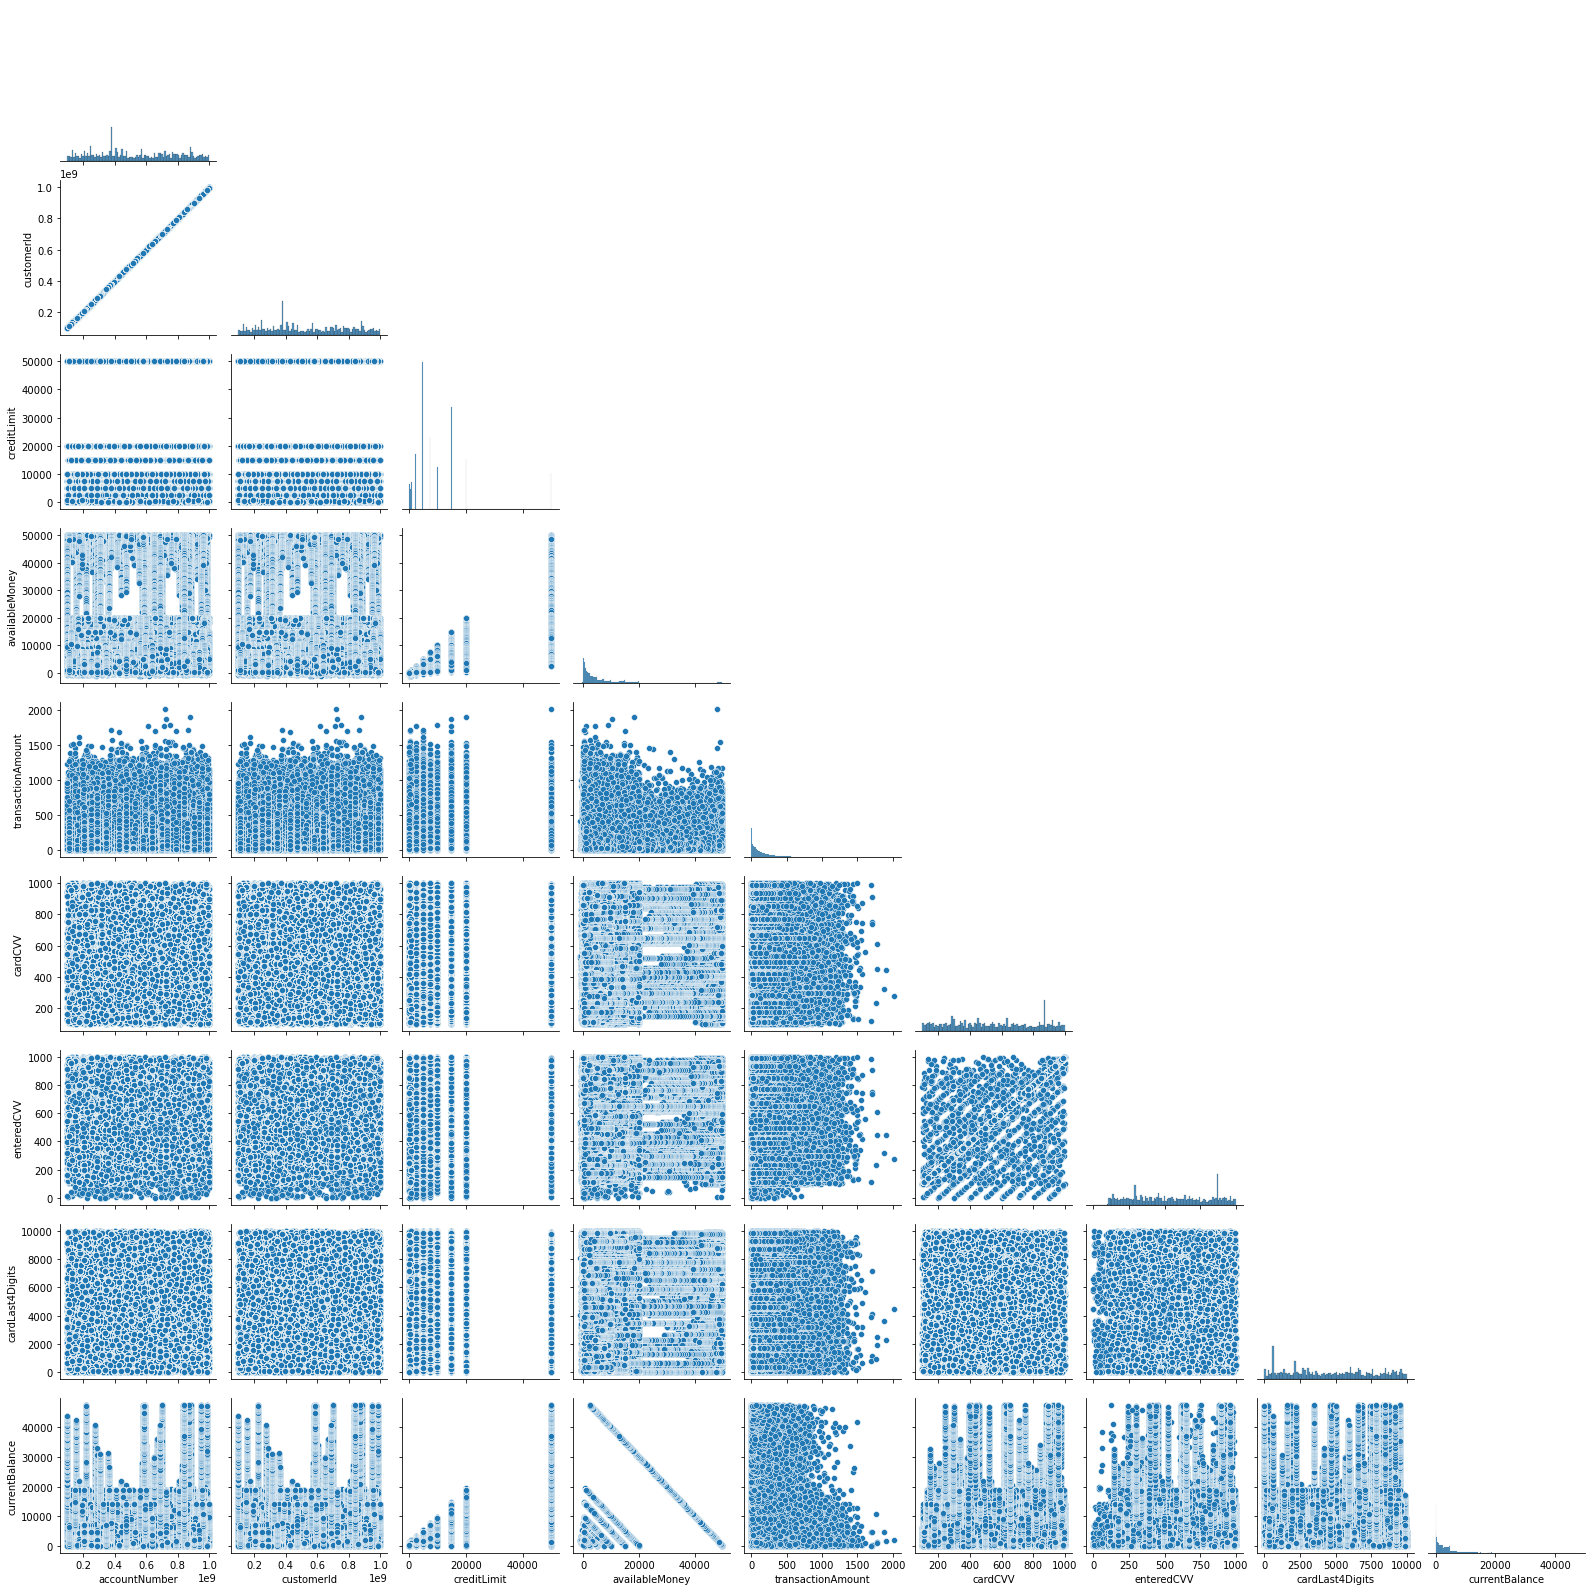

In [36]:
sns.pairplot(df_1[numerical_features], corner=True)
plt.show()

In [808]:
print('currentBalance + availableMoney == creditLimit: {},\
        \ncurrentBalance + availableMoney != creditLimit: {}'\
      .format(df[df['currentBalance']+df['availableMoney'] == df['creditLimit']].shape[0],\
    df[df['currentBalance']+df['availableMoney'] != df['creditLimit']].shape[0]))

currentBalance + availableMoney == creditLimit: 786363,        
currentBalance + availableMoney != creditLimit: 0


In [809]:
print('accountNumber == customerId: {},\
        \naccountNumber != customerId: {}'\
      .format(df[df['accountNumber'] == df['customerId']].shape[0],\
    df[df['accountNumber'] != df['customerId']].shape[0]))

accountNumber == customerId: 786363,        
accountNumber != customerId: 0


### Findings: 
1. 'creditLimit' is discrete, it can be treated as categorical feature.

2. skewed feature: 'transactionAmount', 'currentBalance', 'availableMoney', 

3. currentBalance + availableMoney = creditLimit

4. accountNumber & CustomerId are exactly identical, keep only one of them.

In [810]:
df = df.drop(['accountNumber'], axis=1)

## Hypothesis to be validated:

Q1. any pattern in numerical feature: availableMoney, creditimit, currentBalance, transactionAmount in commiting fraud transaction?

Q2. is there any clue for finding fraud transaction when cardCVV != enteredCVV?

Q3. any pattern in currentBalance/creditimit, transactionAmount/currentBalance, transactionAmount/creditimit in commiting fraud transaction?

Q4. any pattern in datetime in commiting fraud transaction?

Q5. any pattern in categorical feature: merchantCategoryCode, merchantName, posConditionCode in commiting fraud transaction?

Q6. any behavior pattern in customer who tends to have fraud transaction? say # of cards?

Q7. is there any cluster found in fraud and non-fraud transaction?

### Q1. any pattern in numerical feature: availableMoney, creditimit, currentBalance, transactionAmount in commiting fraud transaction?

In [576]:
def plot_mean_wrt_fraud(df, col_name, func, ax, index, ncols):
    _df = df[['isFraud', col_name]].copy()
    _df[col_name] = _df[col_name].astype(float)
    agg_df = _df.groupby('isFraud').agg({col_name: func})
    title = '{:.0f}:{:.0f}'.format(agg_df[col_name][0], agg_df[col_name][1])
    agg_df.plot.bar(label=col_name, ax=ax[index//ncols][index%ncols], legend=True)
    
    ax[index//ncols][index%ncols].set_title(title)

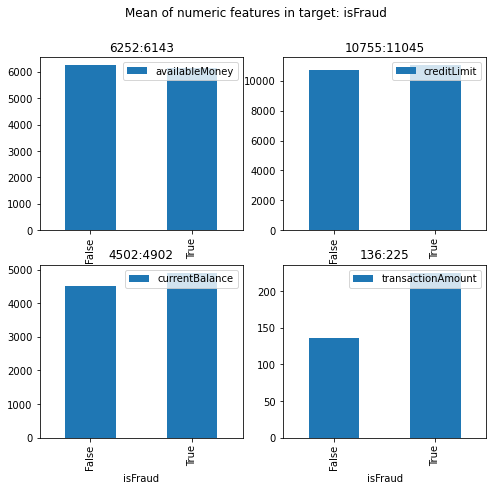

In [577]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 7))

plt.suptitle('Mean of numeric features in target: isFraud')

for index, col in enumerate(['availableMoney', 'creditLimit', 'currentBalance', 'transactionAmount']):
    plot_mean_wrt_fraud(df, col,'mean', ax, index, 2)

### Insight:

High transaction amount is a good indicator to identify fraud transaction.

In [578]:
df['transactionAmount'].min(), df['transactionAmount'].max()

(Decimal('0.00'), Decimal('2011.54'))

In [579]:
df['currentBalance'].min(), df['currentBalance'].max()

(Decimal('0.00'), Decimal('47498.81'))

### Log transform skewed feature

In [811]:
df['transactionAmount_log'] = df['transactionAmount'].apply(lambda x: math.log(x+1))
df['currentBalance_log'] = df['currentBalance'].apply(lambda x: math.log(x+1))

### Q2. is there any clue for finding fraud transaction when cardCVV != enteredCVV?

In [812]:
df['CVV_correct'] = np.where( df['cardCVV'] == df['enteredCVV'], True, False)

In [582]:
df.groupby(['CVV_correct', 'isFraud']).agg({'isFraud': 'count'})\
    .rename_axis(index={'isFraud': 'isFraudValue'})\
    .rename(columns = {'isFraud': 'Count Ratio'})\
    .groupby(level=0).apply(lambda x: x / float(x.sum())).unstack()

Count Ratio      
isFraudValue       False True 
CVV_correct                   
False              0.971 0.029
True               0.984 0.016

In [813]:
df = df.drop(['cardCVV', 'enteredCVV'], axis=1)

### Insight:

When cardCVV != enteredCVV, it has almost as two times as risky of being fraud transaction compared to cardCVV == enteredCVV

### Q3. any pattern in currentBalance/creditimit, transactionAmount/currentBalance, transactionAmount/creditimit in commiting fraud transaction?

In [814]:
df['balance/limit'] = df['currentBalance']/df['creditLimit']
df['transaction/balance'] = df['transactionAmount']/(df['currentBalance']+1)
df['transaction/limit'] = df['transactionAmount']/df['creditLimit']

In [587]:
def plot_kde_wrt_fraud(df, col_name, ax, index, ncols):
    _df = df[['isFraud', col_name]].copy()
    _df[col_name] = _df[col_name].astype(float)
    agg_df = _df.groupby('isFraud')[col_name]\
            .plot.kde(ax=ax[index//ncols][index%ncols],legend=True)
    
    ax[index//ncols][index%ncols].set_title(col_name)


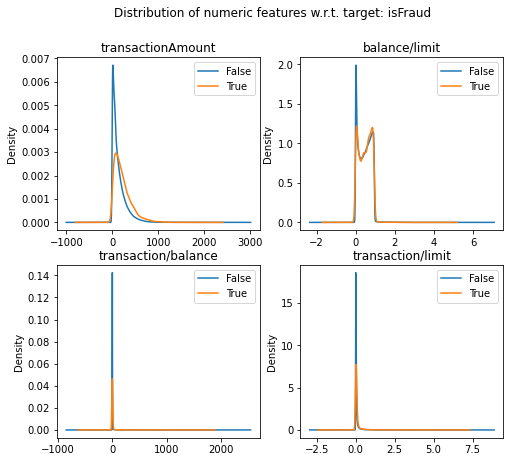

In [541]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 7))

plt.suptitle('Distribution of numeric features w.r.t. target: isFraud')

for index, col in enumerate(['transactionAmount', 'balance/limit', 'transaction/balance', 'transaction/limit']):
    plot_kde_wrt_fraud(df, col, ax, index, 2)

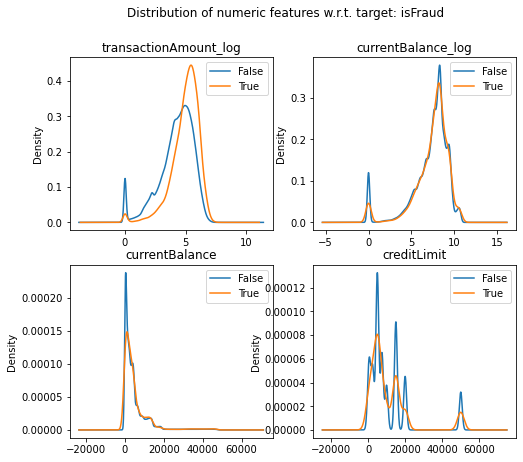

In [542]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 7))

plt.suptitle('Distribution of numeric features w.r.t. target: isFraud')

for index, col in enumerate(['transactionAmount_log', 'currentBalance_log', 'currentBalance', 'creditLimit']):
    plot_kde_wrt_fraud(df, col, ax, index, 2)

### Thought:

Except creditLimit, above features can use Binning technique to encode.

### Q4. any pattern in datetime in commiting fraud transaction?

In [543]:
# plot by year

# seasonal decompose



#### The duriation between account open date and transaction date

In [815]:
df['days_after_signup'] = (df['transactionDateTime'] - df['accountOpenDate']).astype('timedelta64[D]')
df.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,currentBalance_log,CVV_correct,balance/limit,transaction/balance,transaction/limit,days_after_signup
0,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,1803,PURCHASE,0.0,False,False,False,4.601,0.000,True,0,98.55,0.01971,518.000
1,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,767,PURCHASE,0.0,True,False,False,4.324,0.000,True,0,74.51,0.014902,577.000
2,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,767,PURCHASE,0.0,False,False,False,2.137,0.000,True,0,7.47,0.001494,605.000
3,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,767,PURCHASE,0.0,False,False,False,2.137,0.000,True,0,7.47,0.001494,637.000
4,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,3143,PURCHASE,0.0,True,False,False,4.279,0.000,True,0,71.18,0.014236,231.000


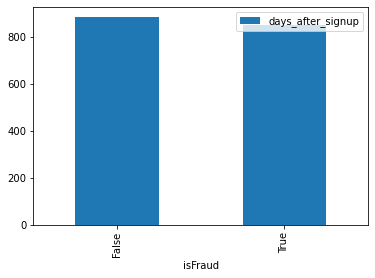

In [545]:
df.groupby(['isFraud'])['days_after_signup'].mean().plot.bar()
plt.legend()
plt.show()

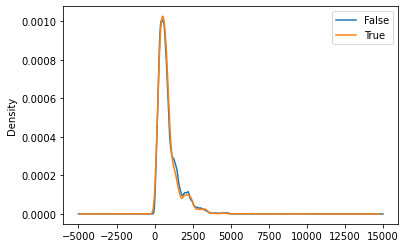

In [546]:
df.groupby(['isFraud'])['days_after_signup'].plot.kde()
plt.legend()
plt.show()

### Q5. any pattern in categorical feature: merchantCategoryCode, merchantName, posConditionCode in commiting fraud transaction?

In [547]:
categorical_features

['merchantName',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'transactionType']

In [548]:
df.groupby(['acqCountry','isFraud']).agg({'isFraud': 'count'})\
    .rename_axis(index={'isFraud': 'isFraudValue'})\
    .groupby(level=0).apply(lambda x: x / float(x.sum()))\
    .reset_index().query('isFraudValue == True')[['acqCountry', 'isFraud']]\
    .sort_values([('isFraud')], ascending=False)

,acqCountry,isFraud
1,CAN,0.023
3,MEX,0.020
5,PR,0.018
7,US,0.016


In [549]:
def plot_fraud_ratio_by_category(df, col_name, ax, index, ncols):
    _df = df[['isFraud', col_name]].copy()
    agg_df = _df.groupby([col_name, 'isFraud']).agg({'isFraud': 'count'})\
                .rename_axis(index={'isFraud': 'isFraudValue'})\
                .groupby(level=0).apply(lambda x: x / float(x.sum()))\
                .reset_index().query('isFraudValue == True')[[col_name, 'isFraud']]\
                .sort_values([('isFraud')], ascending=False)\
                .plot.bar(x=col_name, y='isFraud', ax=ax[index//ncols][index%ncols], legend=True)
    
    ax[index//ncols][index%ncols].set_title(col_name)


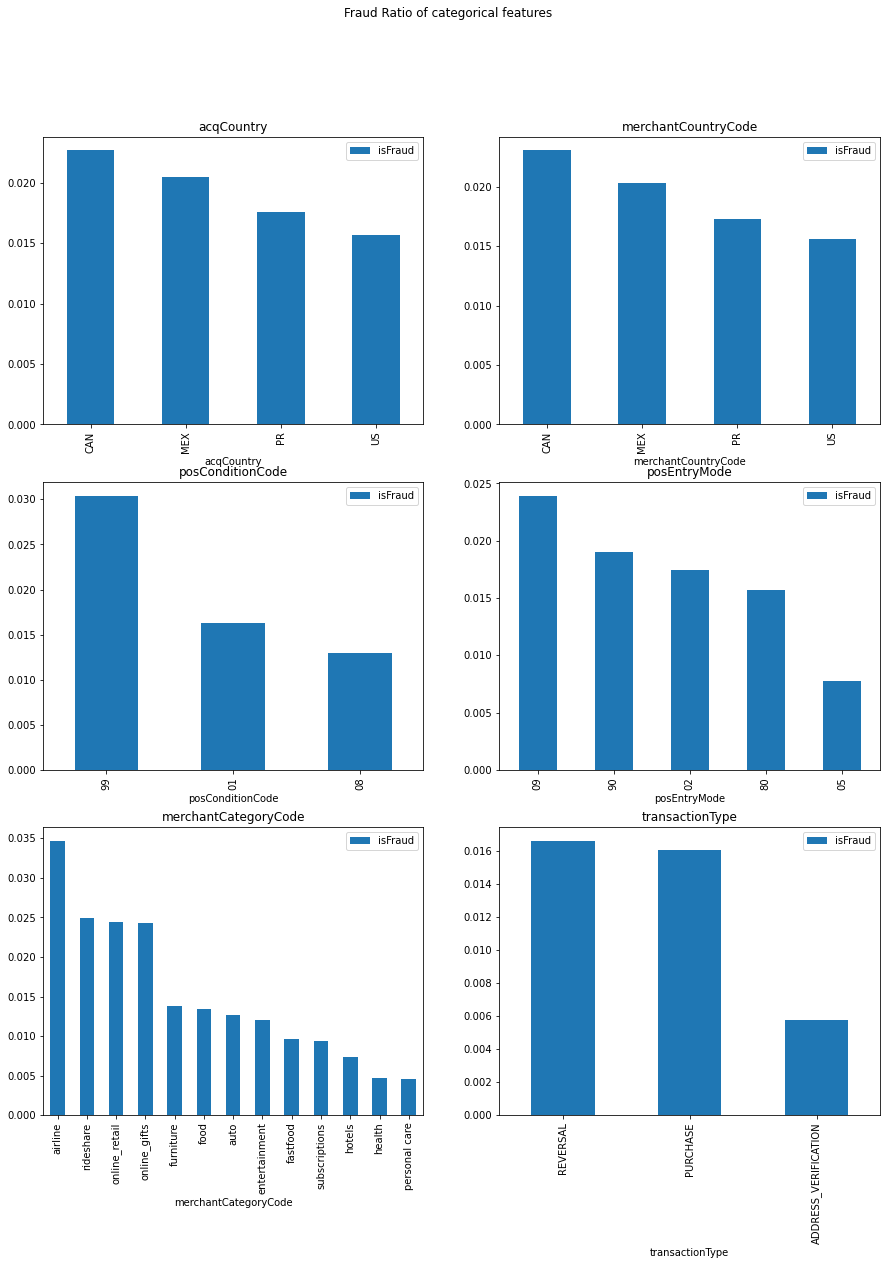

In [550]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15, 18))

plt.suptitle('Fraud Ratio of categorical features')

for index, col in enumerate(['acqCountry', 'merchantCountryCode', 'posConditionCode',\
                             'posEntryMode','merchantCategoryCode','transactionType']):
    plot_fraud_ratio_by_category(df, col, ax, index, 2)

### Thought:

posCondition = 99 is 2 times risky than posCondition = 01 or 08.

posEntryMode = 09 is 3 times risky than posEntryMode = 05.

merchantCategoryCode = airline is the most risky in committing fraud transaction.

transactionType = REVERSAL & PURCHASE are more risky than transactionType = ADDRESS_VERIFICATION.

### when acqCountry != merchantCountryCode

In [816]:
df['isDomesticTransaction'] = np.where(df['merchantCountryCode'] == df['acqCountry'], True, False)

In [552]:
df.groupby(['isDomesticTransaction', 'isFraud']).agg({'isFraud': 'count'})\
    .rename_axis(index={'isFraud': 'isFraudValue'})\
    .rename(columns = {'isFraud': 'Count Ratio'})\
    .groupby(level=0).apply(lambda x: x / float(x.sum())).unstack()

Count Ratio      
isFraudValue                False True 
isDomesticTransaction                  
False                       0.968 0.032
True                        0.984 0.016

In [819]:
df[df['merchantCountryCode'] != df['acqCountry']].shape[0]

4632

In [820]:
df = df.drop(['merchantCountryCode'], axis=1)

### Insight:

When acqCountry != merchantCountryCode, there are two times higher risky in committing fraud transaction.

### merchantName

In [553]:
df['merchantName'].value_counts()

AMC                              37942
EZ Putt Putt                     30712
Uber                             25613
Lyft                             25523
oldnavy.com                      16992
staples.com                      16980
alibaba.com                      16959
apple.com                        16898
walmart.com                      16873
cheapfast.com                    16858
ebay.com                         16842
target.com                       16813
amazon.com                       16780
sears.com                        16755
discount.com                     16731
gap.com                          16675
Rodeway Inn                      12020
Universe Massage                 11578
Regal Cinemas                    11444
Subway                            9693
Wendys                            9136
Hilton Hotels                     9127
Domino's Pizza                    8448
Fresh Online Services             8384
Blue Mountain eCards              8372
Fresh Flowers            

In [452]:
df['merchantName'] = df['merchantName'].str.split(' #').str[0]

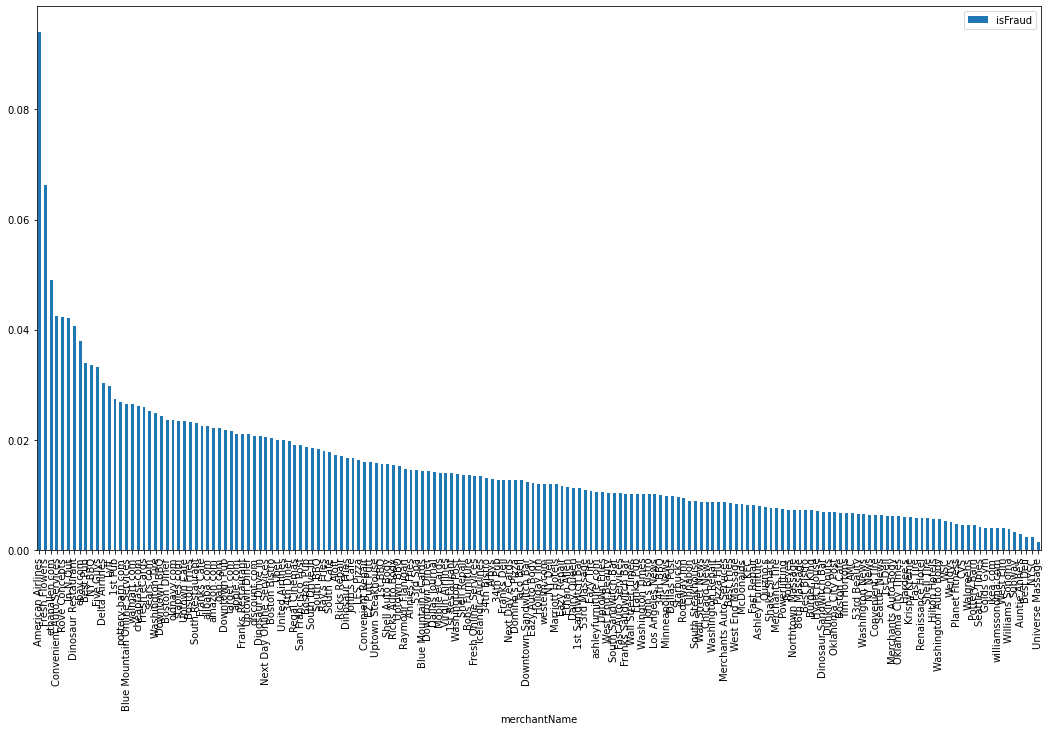

In [453]:
g = df.groupby(['merchantName', 'isFraud']).agg({'isFraud': 'count'})\
                .rename_axis(index={'isFraud': 'isFraudValue'})\
                .groupby(level=0).apply(lambda x: x / float(x.sum()))\
                .reset_index().query('isFraudValue == True')[['merchantName', 'isFraud']]\
                .sort_values([('isFraud')], ascending=False)\
                .plot.bar(x='merchantName', y='isFraud', figsize=(18, 10))

In [454]:
df.groupby(['merchantName', 'isFraud']).agg({'isFraud': 'count'})\
                .rename_axis(index={'isFraud': 'isFraudValue'})\
                .groupby(level=0).apply(lambda x: x / float(x.sum()))\
                .reset_index().query('isFraudValue == True')[['merchantName', 'isFraud']]\
                .sort_values([('isFraud')], ascending=False).head(20)

,merchantName,isFraud
32,American Airlines,0.094
145,Fresh Flowers,0.066
355,ethanallen.com,0.049
77,Convenient Auto Services,0.043
245,Rove Concepts,0.042
164,In-N-Out,0.042
98,Dinosaur Restaurant,0.041
353,ebay.com,0.038
50,Best Pub,0.034
197,NY BBQ,0.034


### Insight:

MerchanName such as American Airlines has high probability for being fraud.

### Q6. any behavior pattern in customer who tends to have fraud transaction? say # of cards?

In [449]:
customer_wt_fraud = df.groupby(['customerId', 'isFraud']).agg({'isFraud': 'count'})\
                    .rename_axis(index={'isFraud': 'isFraudValue'})\
                    .groupby(level=0).apply(lambda x: x / float(x.sum()))\
                    .reset_index().query('isFraudValue == False')[['customerId', 'isFraud']]
customer_wt_fraud['isFraud'] = 1 - customer_wt_fraud['isFraud']

customer_wt_fraud.head()

,customerId,isFraud
0,100088067,0.013
2,100108752,0.000
3,100328049,0.000
4,100663626,0.000
5,100737756,0.006


#### by counting the how many unique cardLast4Digits a customer has to infer how many cards he has:

In [450]:
customer_has_cards = df.groupby(['customerId', 'cardLast4Digits']).agg({'cardLast4Digits': 'count'})\
    .groupby(level=0).apply(lambda x: len(np.unique(x)))

customer_has_cards.to_frame(name="numOfCards").head()

,numOfCards
customerId,
100088067,2
100108752,1
100328049,2
100663626,1
100737756,1


In [451]:
customer_fraud_cards = customer_wt_fraud.merge(customer_has_cards.to_frame(name="numOfCards"), \
                                               left_on='customerId', right_index=True)
customer_fraud_cards.sort_values(by='isFraud', ascending=False).head()

,customerId,isFraud,numOfCards
4433,666461201,0.500,1
3111,494400203,0.500,1
1422,275266909,0.333,2
6584,938195288,0.307,2
1735,319012201,0.286,1


<AxesSubplot:xlabel='numOfCards'>

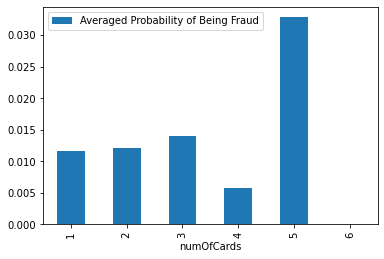

In [595]:
customer_fraud_cards.groupby(['numOfCards']).agg({'isFraud': 'mean'})\
                    .rename(columns={'isFraud': 'Averaged Probability of Being Fraud'})\
                    .reset_index().plot.bar(x='numOfCards')

In [824]:
df = df.drop(['cardLast4Digits'], axis=1)

In [825]:
df = df.merge(customer_has_cards.to_frame(name="numOfCards"), left_on='customerId', right_index=True)

### Insight:

Having cards of 5 are more likely to have fraud transactions.

Having cards of 6 are least likely to have fraud transactions.

## Plotting correlation matrix

In [826]:
df['creditLimit'] = df['creditLimit'].astype(str)

df['availableMoney'] = df['availableMoney'].astype(float)
df['currentBalance'] = df['currentBalance'].astype(float)
df['transactionAmount'] = df['transactionAmount'].astype(float)

df['balance/limit'] = df['balance/limit'].astype(float)
df['transaction/balance'] = df['transaction/balance'].astype(float)
df['transaction/limit'] = df['transaction/limit'].astype(float)

# # now df.loc[2410, 'availableMoney'] == Decimal('4116.64'), but its raw value was 4116.639999999999

In [827]:
df = df.drop('availableMoney', axis = 1)

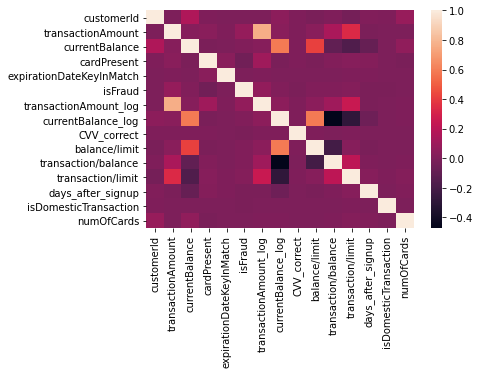

In [828]:
corr_list= df.corr()
sns.heatmap(corr_list)
plt.show()

In [829]:
# Create correlation matrix
corr_matrix = corr_list.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
cor_features = [column for column in upper.columns if any(upper[column] > 0.9)]
cor_features

[]

In [830]:
# df.to_pickle('data/col_eda')

In [54]:
df = pd.read_pickle('data/col_eda')
df.head()

,customerId,creditLimit,transactionDateTime,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,currentBalance_log,CVV_correct,balance/limit,transaction/balance,transaction/limit,days_after_signup,isDomesticTransaction,numOfCards
0,737265056,5000.0,2016-08-13 14:27:32,98.550,Uber,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,PURCHASE,0.000,False,False,False,4.601,0.000,True,0.000,98.550,0.020,518.000,True,2
1,737265056,5000.0,2016-10-11 05:05:54,74.510,AMC,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,PURCHASE,0.000,True,False,False,4.324,0.000,True,0.000,74.510,0.015,577.000,True,2
2,737265056,5000.0,2016-11-08 09:18:39,7.470,Play Store,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,PURCHASE,0.000,False,False,False,2.137,0.000,True,0.000,7.470,0.001,605.000,True,2
3,737265056,5000.0,2016-12-10 02:14:50,7.470,Play Store,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,PURCHASE,0.000,False,False,False,2.137,0.000,True,0.000,7.470,0.001,637.000,True,2
4,830329091,5000.0,2016-03-24 21:04:46,71.180,Tim Hortons,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,PURCHASE,0.000,True,False,False,4.279,0.000,True,0.000,71.180,0.014,231.000,True,1


# 4. Feature Preprocessing

In [55]:
df = df.drop(['customerId', 'transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange'], axis=1)

In [56]:
df.select_dtypes(include=['bool']).columns

# 'cardPresent', 'expirationDateKeyInMatch', 'isFraud', 'CVV_correct', 'isDomesticTransaction'

Index(['cardPresent', 'expirationDateKeyInMatch', 'isFraud', 'CVV_correct',
       'isDomesticTransaction'],
      dtype='object')

In [57]:
df.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns

# 'transactionAmount', 'currentBalance', 'transactionAmount_log', 'currentBalance_log', \
# 'balance/limit', 'transaction/balance', 'transaction/limit', 'numOfCards', 'days_after_signup'

Index(['transactionAmount', 'currentBalance', 'transactionAmount_log',
       'currentBalance_log', 'balance/limit', 'transaction/balance',
       'transaction/limit', 'days_after_signup', 'numOfCards'],
      dtype='object')

In [58]:
df.select_dtypes(include=['object']).columns

# 'creditLimit',  'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',\
#  'merchantCategoryCode', 'transactionType'    

Index(['creditLimit', 'merchantName', 'acqCountry', 'posEntryMode',
       'posConditionCode', 'merchantCategoryCode', 'transactionType'],
      dtype='object')

### Transform boolean features into int

In [59]:
df['cardPresent'] = np.where(df['cardPresent'], 1, 0)
df['expirationDateKeyInMatch'] = np.where(df['expirationDateKeyInMatch'], 1, 0)

df['CVV_correct'] = np.where(df['CVV_correct'], 1, 0)
df['isDomesticTransaction'] = np.where(df['isDomesticTransaction'], 1, 0)

df['isFraud'] = np.where(df['isFraud'], 1, 0)

### Train test split (default to stratified sampling)

In [60]:
y = df['isFraud']
X = df.drop(['isFraud'], axis=1)

# default to stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

print('the shape of X_train :', X_train.shape, 'The shape of X_test', X_test.shape)

the shape of X_train : (589772, 20) The shape of X_test (196591, 20)


### Standardise numeric features

In [61]:
num_cols = ['transactionAmount', 'currentBalance', 'transactionAmount_log', 'currentBalance_log', \
'balance/limit', 'transaction/balance', 'transaction/limit', 'numOfCards', 'days_after_signup']

scaler = preprocessing.StandardScaler()

# 转化后的数据是 numpy 数组
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

### Encoding Categorical features

In [62]:
cat_cols = ['creditLimit',  'merchantName', 'acqCountry', 'posEntryMode', 'posConditionCode',\
 'merchantCategoryCode', 'transactionType']

df[cat_cols].nunique()

creditLimit              10
merchantName            205
acqCountry                4
posEntryMode              5
posConditionCode          3
merchantCategoryCode     19
transactionType           3
dtype: int64

### Thought:

**Encoding method for each categorical feature:**

creditLimit   ------------      target-encoding + binary-encoding
<br>
merchantName ------------           target-encoding +  binary-encoding + ~~hashing~~
<br>
acqCountry ------------             target-encoding + one-hot-encoding
<br>
posEntryMode ------------           target-encoding + one-hot-encoding
<br>
posConditionCode ------------       target-encoding+ one-hot-encoding
<br>
merchantCategoryCode ------------   target-encoding + binary-encoding
<br>
transactionType ------------        target-encoding+ one-hot-encoding

In [622]:
### Ratio-encoding features

# it only calculates posterior probability, which can be improved by looking at prior probability as well to help smooth out the encoded value so as to not give too much weight to the target encoded feature.

# def ratio_encoding(tr_df, test_df, agg_col, new_col):
#     map_series = 100 - tr_df.groupby([agg_col, 'isFraud']).agg({'isFraud': 'count'})\
#                         .rename(columns = {'isFraud': 'isFraudValue'})\
#                         .groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))\
#                         .query('isFraud == False').reset_index().set_index(agg_col)['isFraudValue']

#     tr_df[new_col] = tr_df[agg_col].map(map_series)
#     test_df[new_col] = test_df[agg_col].map(map_series)
    
#     return tr_df, test_df

### Target-encoding categorical features

target encoding calculates the mean of the target variable for each category and replace the category variable with the mean value. In the case of the categorical target variables, the posterior probability of the target replaces each category

features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data. by looking at prior probability as well it helps smooth out the encoded value so as to not give too much weight to the target encoded feature.

In [63]:
def target_encoding(tr_df, test_df, tr_y, test_y, col):
    encoder=ce.TargetEncoder(cols=col)
    tr_encoded = encoder.fit_transform(tr_df[col], tr_y).rename(columns={col: str(col)+'_tenc'})
    test_encoded = encoder.transform(test_df[col], test_y).rename(columns={col: str(col)+'_tenc'})
   
    tr_encoded.index = tr_df.index
    test_encoded.index = test_df.index
    
    tr_df = pd.concat([tr_df, tr_encoded], axis=1)
    test_df = pd.concat([test_df, test_encoded], axis=1)

    return tr_df, test_df

In [64]:
for col in cat_cols:
    X_train, X_test = target_encoding(X_train, X_test, y_train, y_test, col)

In [65]:
X_train.head()
# X_test.head()

,creditLimit,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,transactionAmount_log,currentBalance_log,CVV_correct,balance/limit,transaction/balance,transaction/limit,days_after_signup,isDomesticTransaction,numOfCards,creditLimit_tenc,merchantName_tenc,acqCountry_tenc,posEntryMode_tenc,posConditionCode_tenc,merchantCategoryCode_tenc,transactionType_tenc
247233,5000.0,0.477,Blue Mountain eCards,US,02,08,online_gifts,PURCHASE,-0.061,0,0,0.774,0.482,1,1.179,-0.143,-0.085,-0.356,1,-0.698,0.017,0.014,0.016,0.018,0.013,0.024,0.016
733168,2500.0,1.244,Boston Diner,US,02,01,food,PURCHASE,-0.420,1,0,1.080,0.098,1,0.838,-0.139,0.394,-0.862,1,-0.698,0.015,0.030,0.016,0.018,0.016,0.013,0.016
103031,7500.0,-0.831,Uber,US,09,01,rideshare,PURCHASE,0.211,0,0,-1.081,0.648,1,1.050,-0.144,-0.303,1.704,1,-0.698,0.013,0.020,0.016,0.024,0.016,0.025,0.016
576728,10000.0,0.652,Oklahoma City Post,US,05,01,subscriptions,PURCHASE,-0.093,0,0,0.856,0.459,1,-0.223,-0.143,-0.185,5.078,1,0.797,0.013,0.004,0.016,0.008,0.016,0.009,0.016
703102,7500.0,1.569,Fresh eCards,US,05,08,online_gifts,PURCHASE,-0.417,0,0,1.179,0.103,1,-0.707,-0.139,-0.042,0.734,1,-0.698,0.013,0.024,0.016,0.008,0.013,0.024,0.016


# 5. Missing value imputation

### KNNImputer:

A critical point here is that the KNN Imptuer is a distance-based imputation method and it requires us to normalize our data. Otherwise, the different scales of our data will lead the KNN Imputer to generate biased replacements for the missing values.

KNN Imputer maintains the value and variability of your datasets and yet it is more precise and efficient than using the average values.

In [66]:
sel_col = [str(cat) + '_tenc' for cat in cat_cols] + num_cols + \
        ['cardPresent', 'expirationDateKeyInMatch', 'CVV_correct', 'isDomesticTransaction']

sel_X_train = X_train[sel_col]
sel_X_test = X_test[sel_col]

len(sel_col)

20

In [67]:
KNN_imputer = KNNImputer(n_neighbors=19)
X_train_f = pd.DataFrame(KNN_imputer.fit_transform(sel_X_train), columns = sel_X_train.columns, index = sel_X_train.index)
X_test_f = pd.DataFrame(KNN_imputer.transform(sel_X_test), columns = sel_X_test.columns, index = sel_X_test.index)

In [68]:
# check any null value in row-wise
X_train_f[X_train_f.isnull().any(axis=1)]

,creditLimit_tenc,merchantName_tenc,acqCountry_tenc,posEntryMode_tenc,posConditionCode_tenc,merchantCategoryCode_tenc,transactionType_tenc,transactionAmount,currentBalance,transactionAmount_log,currentBalance_log,balance/limit,transaction/balance,transaction/limit,numOfCards,days_after_signup,cardPresent,expirationDateKeyInMatch,CVV_correct,isDomesticTransaction


In [69]:
X_test_f[X_test_f.isnull().any(axis=1)]

,creditLimit_tenc,merchantName_tenc,acqCountry_tenc,posEntryMode_tenc,posConditionCode_tenc,merchantCategoryCode_tenc,transactionType_tenc,transactionAmount,currentBalance,transactionAmount_log,currentBalance_log,balance/limit,transaction/balance,transaction/limit,numOfCards,days_after_signup,cardPresent,expirationDateKeyInMatch,CVV_correct,isDomesticTransaction


### Q7. is there any cluster found in fraud and non-fraud transaction?

In [970]:
km_model = []
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k,
                n_init = 30, # Number of time of run with different centroid seeds
                random_state = 2021) #random number for centroid initialization
    km = km.fit(X_train_f)
    Sum_of_squared_distances.append(km.inertia_) # inertia_:  Within-Cluster-Sum of Squared Errors
    km_model.append(km)


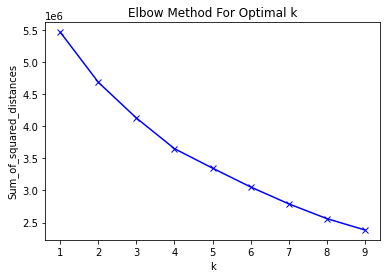

In [971]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [70]:
km_filename = 'kmeans_k4.joblib'

In [ ]:
# save model
joblib.dump(km_model[3], km_filename)

In [71]:
# load model
km_model_k4 = joblib.load(km_filename)

In [72]:
# choose k=4
train_cluster = km_model_k4.predict(X_train_f)
test_cluster = km_model_k4.predict(X_test_f)

In [73]:
X_train = pd.DataFrame(np.hstack((X_train, train_cluster[:, np.newaxis])), \
             columns=X_train.columns.append(pd.Index(['cluster'])), index = X_train.index)

X_test = pd.DataFrame(np.hstack((X_test, test_cluster[:, np.newaxis])), \
             columns=X_test.columns.append(pd.Index(['cluster'])), index = X_test.index)

### Target-encoding cluster

In [74]:
X_train, X_test = target_encoding(X_train, X_test, y_train, y_test, 'cluster')

In [75]:
X_train.head()

,creditLimit,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,transactionAmount_log,currentBalance_log,CVV_correct,balance/limit,transaction/balance,transaction/limit,days_after_signup,isDomesticTransaction,numOfCards,creditLimit_tenc,merchantName_tenc,acqCountry_tenc,posEntryMode_tenc,posConditionCode_tenc,merchantCategoryCode_tenc,transactionType_tenc,cluster,cluster_tenc
247233,5000.0,0.477,Blue Mountain eCards,US,02,08,online_gifts,PURCHASE,-0.061,0,0,0.774,0.482,1,1.179,-0.143,-0.085,-0.356,1,-0.698,0.017,0.014,0.016,0.018,0.013,0.024,0.016,1,0.013
733168,2500.0,1.244,Boston Diner,US,02,01,food,PURCHASE,-0.420,1,0,1.080,0.098,1,0.838,-0.139,0.394,-0.862,1,-0.698,0.015,0.030,0.016,0.018,0.016,0.013,0.016,2,0.029
103031,7500.0,-0.831,Uber,US,09,01,rideshare,PURCHASE,0.211,0,0,-1.081,0.648,1,1.050,-0.144,-0.303,1.704,1,-0.698,0.013,0.020,0.016,0.024,0.016,0.025,0.016,1,0.013
576728,10000.0,0.652,Oklahoma City Post,US,05,01,subscriptions,PURCHASE,-0.093,0,0,0.856,0.459,1,-0.223,-0.143,-0.185,5.078,1,0.797,0.013,0.004,0.016,0.008,0.016,0.009,0.016,2,0.029
703102,7500.0,1.569,Fresh eCards,US,05,08,online_gifts,PURCHASE,-0.417,0,0,1.179,0.103,1,-0.707,-0.139,-0.042,0.734,1,-0.698,0.013,0.024,0.016,0.008,0.013,0.024,0.016,2,0.029


In [76]:
X_train['cluster_tenc'].value_counts()

0.013    238439
0.010    213575
0.029    128376
0.025      9382
Name: cluster_tenc, dtype: int64

### Insight:

After k-means clustering, some clusters can give relatively higher probability in finding fraud transaction.

# 6. Feature Engineering

### Binary-encoding features

categorical feature is first converted into numerical using an ordinal encoder. Then the numbers are transformed in the binary number. After that binary value is split into different columns.

In [77]:
def binary_encoding(tr_df, test_df, col):
    encoder = ce.BinaryEncoder(cols=[col], drop_invariant = True)
    tr_encoded = encoder.fit_transform(tr_df[col])
    test_encoded = encoder.transform(test_df[col])
    
    tr_encoded.columns = [col+'_b' for col in encoder.get_feature_names()]
    
    tr_encoded.index = tr_df.index
    test_encoded.index = test_df.index
    
    tr_df = pd.concat([tr_df, tr_encoded], axis=1)
    test_df = pd.concat([test_df, test_encoded], axis=1)

    return tr_df, test_df

In [78]:
for col in ['creditLimit', 'merchantCategoryCode', 'merchantName']:
    X_train, X_test = binary_encoding(X_train, X_test, col)

In [79]:
X_train.head()
# X_test.head()

,creditLimit,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,transactionAmount_log,currentBalance_log,CVV_correct,balance/limit,transaction/balance,transaction/limit,days_after_signup,isDomesticTransaction,numOfCards,creditLimit_tenc,merchantName_tenc,acqCountry_tenc,posEntryMode_tenc,posConditionCode_tenc,merchantCategoryCode_tenc,transactionType_tenc,cluster,cluster_tenc,creditLimit_1_b,creditLimit_2_b,creditLimit_3_b,creditLimit_4_b,merchantCategoryCode_1_b,merchantCategoryCode_2_b,merchantCategoryCode_3_b,merchantCategoryCode_4_b,merchantCategoryCode_5_b,merchantName_1_b,merchantName_2_b,merchantName_3_b,merchantName_4_b,merchantName_5_b,merchantName_6_b,merchantName_7_b,merchantName_8_b
247233,5000.0,0.477,Blue Mountain eCards,US,02,08,online_gifts,PURCHASE,-0.061,0,0,0.774,0.482,1,1.179,-0.143,-0.085,-0.356,1,-0.698,0.017,0.014,0.016,0.018,0.013,0.024,0.016,1,0.013,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
733168,2500.0,1.244,Boston Diner,US,02,01,food,PURCHASE,-0.420,1,0,1.080,0.098,1,0.838,-0.139,0.394,-0.862,1,-0.698,0.015,0.030,0.016,0.018,0.016,0.013,0.016,2,0.029,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
103031,7500.0,-0.831,Uber,US,09,01,rideshare,PURCHASE,0.211,0,0,-1.081,0.648,1,1.050,-0.144,-0.303,1.704,1,-0.698,0.013,0.020,0.016,0.024,0.016,0.025,0.016,1,0.013,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,1
576728,10000.0,0.652,Oklahoma City Post,US,05,01,subscriptions,PURCHASE,-0.093,0,0,0.856,0.459,1,-0.223,-0.143,-0.185,5.078,1,0.797,0.013,0.004,0.016,0.008,0.016,0.009,0.016,2,0.029,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
703102,7500.0,1.569,Fresh eCards,US,05,08,online_gifts,PURCHASE,-0.417,0,0,1.179,0.103,1,-0.707,-0.139,-0.042,0.734,1,-0.698,0.013,0.024,0.016,0.008,0.013,0.024,0.016,2,0.029,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1


### Hashing features

the Hash encoder represents categorical features using the new dimensions. Hashing transforms the data in lesser dimensions, it may lead to loss of information. 

In [996]:
def hashing(tr_df, test_df, col, n_components):
    encoder = ce.HashingEncoder(cols=[col], n_components=n_components)
    tr_encoded = encoder.fit_transform(tr_df[col])
    test_encoded = encoder.transform(test_df[col])
    
    columns = dict(zip(['col_{}'.format(i) for i in range(n_components)], 
                    ['{}_h{}'.format(col, i) for i in range(n_components)]))
    
    tr_encoded.index = tr_df.index
    test_encoded.index = test_df.index
    
    tr_df = pd.concat([tr_df, tr_encoded], axis=1).rename(columns = columns)
    test_df = pd.concat([test_df, test_encoded], axis=1).rename(columns = columns)

    return tr_df, test_df

In [80]:
# X_train, X_test = hashing(X_train, X_test, 'merchantName', 100)

In [998]:
X_train.head()
# X_test.head()

,creditLimit,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,transactionAmount_log,currentBalance_log,CVV_correct,balance/limit,transaction/balance,transaction/limit,days_after_signup,isDomesticTransaction,numOfCards,creditLimit_tenc,merchantName_tenc,acqCountry_tenc,posEntryMode_tenc,posConditionCode_tenc,merchantCategoryCode_tenc,transactionType_tenc,cluster,cluster_tenc,creditLimit_1,creditLimit_2,creditLimit_3,creditLimit_4,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_h0,merchantName_h1,merchantName_h2,merchantName_h3,merchantName_h4,merchantName_h5,merchantName_h6,merchantName_h7,merchantName_h8,merchantName_h9
170115,2500.0,-0.834,1st Sandwitch Bar,US,09,01,food,PURCHASE,-0.597,1,0,-1.099,-0.368,1,-0.641,-0.143,-0.283,-0.010,1,0.797,0.015,0.012,0.016,0.024,0.016,0.014,0.016,1,0.010,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
660226,5000.0,-0.091,AMC,US,02,01,entertainment,PURCHASE,-0.223,0,0,0.410,0.347,1,0.499,-0.143,-0.177,0.877,1,-0.698,0.017,0.007,0.016,0.018,0.016,0.012,0.016,0,0.013,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
208078,15000.0,-0.138,Franks Restaurant,US,05,01,food,PURCHASE,0.486,1,0,0.369,0.769,1,0.161,-0.144,-0.270,0.774,1,-0.698,0.019,0.023,0.016,0.008,0.016,0.014,0.016,0,0.013,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0
341822,15000.0,-0.380,walmart.com,US,02,01,online_retail,PURCHASE,1.002,0,0,0.113,0.937,1,0.882,-0.144,-0.283,-0.066,1,0.797,0.019,0.027,0.016,0.018,0.016,0.025,0.016,0,0.013,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
632238,15000.0,-0.656,amazon.com,US,02,01,online_retail,PURCHASE,-0.089,0,0,-0.375,0.461,1,-0.642,-0.144,-0.298,3.614,1,-0.698,0.019,0.022,0.016,0.018,0.016,0.025,0.016,1,0.010,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0


### One-Hot-Encoding features

In [81]:
def ohe(tr_df, test_df, col):
    encoder = ce.OneHotEncoder(cols=[col], handle_unknown='return_nan', use_cat_names=True)
    tr_encoded = encoder.fit_transform(tr_df[col])
    test_encoded = encoder.transform(test_df[col])
    
    tr_encoded.index = tr_df.index
    test_encoded.index = test_df.index
    
    tr_df = pd.concat([tr_df, tr_encoded], axis=1)
    test_df = pd.concat([test_df, test_encoded], axis=1)
    
    return tr_df, test_df

In [82]:
for col in ['acqCountry', 'posEntryMode', 'posConditionCode', 'transactionType']:
    X_train, X_test = ohe(X_train, X_test, col)

In [83]:
X_train.head()
# X_test.head()

,creditLimit,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,transactionAmount_log,currentBalance_log,CVV_correct,balance/limit,transaction/balance,transaction/limit,days_after_signup,isDomesticTransaction,numOfCards,creditLimit_tenc,merchantName_tenc,acqCountry_tenc,posEntryMode_tenc,posConditionCode_tenc,merchantCategoryCode_tenc,transactionType_tenc,cluster,cluster_tenc,creditLimit_1_b,creditLimit_2_b,creditLimit_3_b,creditLimit_4_b,merchantCategoryCode_1_b,merchantCategoryCode_2_b,merchantCategoryCode_3_b,merchantCategoryCode_4_b,merchantCategoryCode_5_b,merchantName_1_b,merchantName_2_b,merchantName_3_b,merchantName_4_b,merchantName_5_b,merchantName_6_b,merchantName_7_b,merchantName_8_b,acqCountry_US,acqCountry_MEX,acqCountry_nan,acqCountry_CAN,acqCountry_PR,posEntryMode_02,posEntryMode_09,posEntryMode_05,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_08,posConditionCode_01,posConditionCode_99,posConditionCode_nan,transactionType_PURCHASE,transactionType_ADDRESS_VERIFICATION,transactionType_REVERSAL,transactionType_nan
247233,5000.0,0.477,Blue Mountain eCards,US,02,08,online_gifts,PURCHASE,-0.061,0,0,0.774,0.482,1,1.179,-0.143,-0.085,-0.356,1,-0.698,0.017,0.014,0.016,0.018,0.013,0.024,0.016,1,0.013,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
733168,2500.0,1.244,Boston Diner,US,02,01,food,PURCHASE,-0.420,1,0,1.080,0.098,1,0.838,-0.139,0.394,-0.862,1,-0.698,0.015,0.030,0.016,0.018,0.016,0.013,0.016,2,0.029,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000
103031,7500.0,-0.831,Uber,US,09,01,rideshare,PURCHASE,0.211,0,0,-1.081,0.648,1,1.050,-0.144,-0.303,1.704,1,-0.698,0.013,0.020,0.016,0.024,0.016,0.025,0.016,1,0.013,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,1,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000
576728,10000.0,0.652,Oklahoma City Post,US,05,01,subscriptions,PURCHASE,-0.093,0,0,0.856,0.459,1,-0.223,-0.143,-0.185,5.078,1,0.797,0.013,0.004,0.016,0.008,0.016,0.009,0.016,2,0.029,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000
703102,7500.0,1.569,Fresh eCards,US,05,08,online_gifts,PURCHASE,-0.417,0,0,1.179,0.103,1,-0.707,-0.139,-0.042,0.734,1,-0.698,0.013,0.024,0.016,0.008,0.013,0.024,0.016,2,0.029,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000


### Binning Numerical features 

In [671]:
# def bin_column(tr_df, test_df, col_name, new_col_name, bin_num, minv, maxv):
#     if new_col_name in tr_df.columns:
#         tr_df.drop([new_col_name],axis = 1, inplace=True)
#     if new_col_name in test_df.columns:
#         test_df.drop([new_col_name],axis = 1, inplace=True)

#     bins = np.linspace(minv, maxv, bin_num+1)
#     bins = np.insert(bins, 0, float("-inf"), axis=0)
#     bins = np.insert(bins, len(bins), float("inf"), axis=0)
#     # bins = [-inf, minv, ..., maxv, inf]
#     ss, bins = pd.cut(tr_df[col_name], bins=bins, retbins=True, labels=False) 
#     ss.name = new_col_name
#     tr_df = tr_df.join(ss)

#     test_ss = pd.cut(test_df[col_name], bins=bins, labels=False, include_lowest=True)
#     test_ss.name = new_col_name
#     test_df = test_df.join(test_ss)
  
#     return tr_df, test_df

In [672]:
# bin_num = 8

# X_train, X_test = bin_column(X_train, X_test, 'transactionAmount_log', 'bin_transactionAmount', bin_num, 0, 7)

# X_train, X_test = ratio_encoding(X_train, X_test, 'bin_transactionAmount', 'transactionAmount_ratio')

# X_train.transactionAmount_ratio.value_counts()


# bin_num = 11

# X_train, X_test = bin_column(X_train, X_test, 'currentBalance_log', 'bin_currentBalance', bin_num, 0, 10)

# X_train, X_test = ratio_encoding(X_train, X_test, 'bin_currentBalance', 'currentBalance_ratio')

# X_train.currentBalance_ratio.value_counts()


# bin_num = 5

# X_train, X_test = bin_column(X_train, X_test, 'balance_limit_ratio_log', 'bin_balance_limit_ratio', bin_num, 0, 1.7)

# X_train, X_test = ratio_encoding(X_train, X_test, 'bin_balance_limit_ratio', 'balance_limit_ratio_ratio')

# X_train.balance_limit_ratio_ratio.value_counts()


# bin_num = 6

# X_train, X_test = bin_column(X_train, X_test, 'transaction_balance_ratio_log', 'bin_transaction_balance_ratio', bin_num, 0, 2)

# X_train, X_test = ratio_encoding(X_train, X_test, 'bin_transaction_balance_ratio', 'transaction_balance_ratio_ratio')

# X_train.transaction_balance_ratio_ratio.value_counts()

In [84]:
X_train = X_train.drop(['creditLimit', 'merchantName', 'acqCountry', 'posEntryMode', 'posConditionCode',\
            'merchantCategoryCode', 'transactionType', 'cluster'], axis=1)

X_test = X_test.drop(['creditLimit', 'merchantName', 'acqCountry', 'posEntryMode', 'posConditionCode',\
            'merchantCategoryCode', 'transactionType', 'cluster'], axis=1)

### Remove highly correlated features

In [85]:
KNN_imputer = KNNImputer(n_neighbors=3)
X_train_feng = pd.DataFrame(KNN_imputer.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
X_test_feng = pd.DataFrame(KNN_imputer.transform(X_test), columns = X_test.columns, index = X_test.index)

(589772, 57)


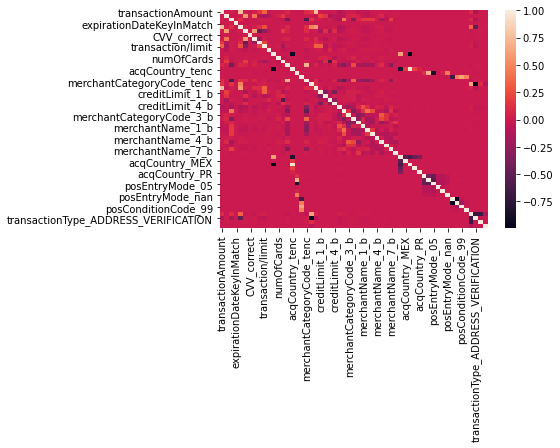

In [86]:
print(X_train_feng.shape)

sns.heatmap(X_train_feng.corr())
plt.show()

In [87]:
# Select upper triangle of correlation matrix
cor_matrix = X_train_feng.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
upper_tri

,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,transactionAmount_log,currentBalance_log,CVV_correct,balance/limit,transaction/balance,transaction/limit,days_after_signup,isDomesticTransaction,numOfCards,creditLimit_tenc,merchantName_tenc,acqCountry_tenc,posEntryMode_tenc,posConditionCode_tenc,merchantCategoryCode_tenc,transactionType_tenc,cluster_tenc,creditLimit_1_b,creditLimit_2_b,creditLimit_3_b,creditLimit_4_b,merchantCategoryCode_1_b,merchantCategoryCode_2_b,merchantCategoryCode_3_b,merchantCategoryCode_4_b,merchantCategoryCode_5_b,merchantName_1_b,merchantName_2_b,merchantName_3_b,merchantName_4_b,merchantName_5_b,merchantName_6_b,merchantName_7_b,merchantName_8_b,acqCountry_US,acqCountry_MEX,acqCountry_nan,acqCountry_CAN,acqCountry_PR,posEntryMode_02,posEntryMode_09,posEntryMode_05,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_08,posConditionCode_01,posConditionCode_99,posConditionCode_nan,transactionType_PURCHASE,transactionType_ADDRESS_VERIFICATION,transactionType_REVERSAL,transactionType_nan
transactionAmount,NaN,0.024,0.037,0.003,0.764,0.040,0.001,0.035,0.147,0.338,0.008,0.001,0.000,0.011,0.077,0.001,0.000,0.003,0.108,0.149,0.761,0.002,0.001,0.008,0.004,0.115,0.047,0.003,0.022,0.021,0.035,0.044,0.002,0.010,0.005,0.002,0.017,0.005,0.000,0.000,0.001,0.000,0.001,0.000,0.001,0.001,0.002,0.003,0.001,0.002,0.002,0.001,0.002,0.105,0.150,0.003,0.003
currentBalance,NaN,NaN,0.010,0.001,0.027,0.587,0.004,0.419,0.100,0.164,0.082,0.000,0.062,0.180,0.012,0.000,0.002,0.000,0.015,0.003,0.046,0.209,0.152,0.157,0.056,0.060,0.053,0.066,0.076,0.049,0.034,0.046,0.019,0.014,0.089,0.015,0.016,0.014,0.000,0.000,0.000,0.000,0.001,0.001,0.003,0.001,0.000,0.001,0.001,0.001,0.001,0.000,0.002,0.008,0.004,0.007,0.001
cardPresent,NaN,NaN,NaN,0.040,0.115,0.013,0.002,0.010,0.012,0.025,0.021,0.001,0.014,0.042,0.419,0.002,0.000,0.002,0.590,0.145,0.025,0.023,0.019,0.029,0.058,0.143,0.418,0.027,0.335,0.081,0.164,0.181,0.179,0.021,0.188,0.066,0.193,0.007,0.003,0.004,0.000,0.002,0.001,0.001,0.000,0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.003,0.103,0.147,0.001,0.004
expirationDateKeyInMatch,NaN,NaN,NaN,NaN,0.005,0.002,0.000,0.001,0.001,0.002,0.002,0.003,0.003,0.000,0.015,0.002,0.001,0.001,0.021,0.006,0.001,0.003,0.004,0.001,0.005,0.006,0.014,0.001,0.010,0.002,0.007,0.006,0.010,0.001,0.009,0.003,0.005,0.001,0.001,0.001,0.003,0.001,0.001,0.002,0.002,0.000,0.001,0.003,0.001,0.001,0.001,0.002,0.001,0.007,0.006,0.004,0.001
transactionAmount_log,NaN,NaN,NaN,NaN,NaN,0.049,0.001,0.041,0.113,0.257,0.008,0.000,0.002,0.012,0.089,0.000,0.000,0.002,0.124,0.482,0.590,0.003,0.004,0.010,0.005,0.118,0.059,0.008,0.003,0.007,0.027,0.048,0.005,0.022,0.021,0.015,0.015,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.003,0.002,0.001,0.002,0.002,0.001,0.000,0.343,0.487,0.003,0.006
currentBalance_log,NaN,NaN,NaN,NaN,NaN,NaN,0.003,0.592,0.471,0.283,0.054,0.002,0.003,0.184,0.071,0.001,0.004,0.000,0.098,0.005,0.020,0.156,0.130,0.125,0.108,0.098,0.044,0.008,0.023,0.011,0.039,0.043,0.004,0.004,0.030,0.013,0.015,0.008,0.000,0.001,0.002,0.000,0.001,0.001,0.002,0.002,0.002,0.003,0.004,0.000,0.000,0.000,0.001,0.018,0.006,0.019,0.002
CVV_correct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002,0.001,0.000,0.000,0.001,0.001,0.001,0.002,0.001,0.004,0.000,0.000,0.002,0.001,0.003,0.000,0.001,0.001,0.004,0.000,0.001,0.001,0.001,0.003,0.003,0.001,0.001,0.002,0.001,0.003,0.001,0.001,0.001,0.000,0.000,0.002,0.002,0.004,0.006,0.001,0.000,0.001,0.001,0.001,0.000,0.001,0.001,0.001,0.000,0.001
balance/limit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.211,0.027,0.016,0.002,0.004,0.047,0.069,0.002,0.006,0.003,0.097,0.006,0.107,0.028,0.094,0.000,0.021,0.090,0.039,0.018,0.011,0.010,0.032,0.036,0.001,0.003,0.007,0.004,0.022,0.004,0.002,0.001,0.002,0.001,0.000,0.001,0.003,0.004,0.003,0.001,0.006,0.000,0.000,0.003,0.002,0.014,0.007,0.012,0.003
transaction/balance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.217,0.003,0.001,0.006,0.050,0.002,0.001,0.001,0.002,0.003,0.022,0.111,0.056,0.00

In [88]:
# Find features with correlation greater than 0.9
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
to_drop

['acqCountry_tenc',
 'acqCountry_nan',
 'posConditionCode_01',
 'transactionType_ADDRESS_VERIFICATION']

In [89]:
# Drop features 
X_train_feng.drop(to_drop, axis=1, inplace=True)
X_test_feng.drop(to_drop, axis=1, inplace=True)
X_train_feng.shape

(589772, 53)

In [90]:
X_train_feng.to_pickle('data/X_train_feng')
y_train.to_pickle('data/y_train')
X_test_feng.to_pickle('data/X_test_feng')
y_test.to_pickle('data/y_test')

In [91]:
X_train_feng = pd.read_pickle('data/X_train_feng')
y_train = pd.read_pickle('data/y_train')
X_test_feng = pd.read_pickle('data/X_test_feng')
y_test = pd.read_pickle('data/y_test')

# 7. Dimension Reduction

1. Reduce the number of predictors

Why:

Having a large number of dimensions in the feature space can mean that the points often represent a small and non-representative sample.

This can dramatically impact the performance of machine learning algorithms, which is generally referred to as the “curse of dimensionality.” Therefore, it is often desirable to reduce the number of input features.

2. Make sure these variables are independent of each other

Dimension reduction combines those highly correlated variables into a set of uncorrelated variables. This will address the problem of multicollinearity.

## 7.1 Linear methods

### PCA (unsupervised)
input should not contain NaN, infinity.

20 components preserve 90% of the variance


Text(0, 0.5, 'cumulative explained variance')

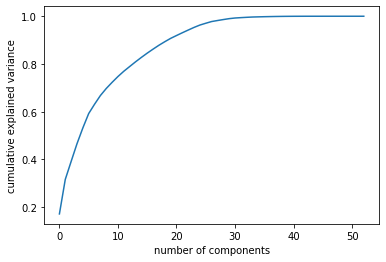

In [92]:
pca = PCA(0.90).fit(X_train_feng)
n_components = pca.n_components_
print('{} components preserve 90% of the variance'.format(n_components))


pca = PCA().fit(X_train_feng)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

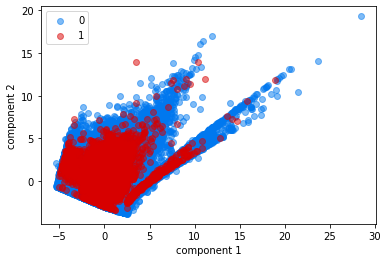

In [93]:
pca = PCA(n_components = n_components)
projected = pca.fit_transform(X_train_feng)

cluster_colors = {0: '#0078ef', 1: '#d80000'}

for g in np.unique(y_train):
    idx = np.where(y_train == g)
    plt.scatter(projected[idx, 0], projected[idx, 1], 
            alpha=0.5, color=cluster_colors[g], label = g)

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend()
plt.show()

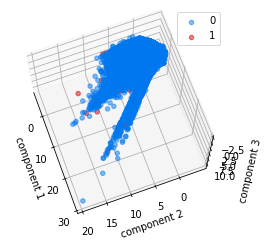

In [95]:
from mpl_toolkits import mplot3d

pca = PCA(n_components = n_components)
projected = pca.fit_transform(X_train_feng)

cluster_colors = {0: '#0078ef', 1: '#d80000'}

ax = plt.axes(projection='3d')

for g in np.unique(y_train):
    idx = np.where(y_train == g)
    ax.scatter3D(projected[idx, 0], projected[idx, 1], projected[idx, 2],
                alpha=0.5, color=cluster_colors[g], label = g)

ax.view_init(azim=200, elev=250)
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')
plt.legend()
plt.show()

### Thought:

The directions of highest variablility are not the direction of highest separation. 

Positive samples and negative samples still have a lot of space in overlap.

But it could potenially be seperable in high dimension, say, using SVM to build linear separable hyperplane, try it.

In [96]:
pca = PCA(n_components = 3)

# transform return: (X_train - pca.mean_).dot(pca.components_.T)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_feng), index = X_train_feng.index)
X_test_pca = pd.DataFrame(pca.transform(X_test_feng), index = X_test_feng.index)

X_train_pca.shape, pca.components_.shape

((589772, 3), (3, 53))

In [1029]:
# transform return: X_train_pca.dot(pca.components_) + pca.mean_
# pca.inverse_transform obtains the projection onto components in signal space, 
# but the inversed data loss some information

X_projected = pca.inverse_transform(X_train_pca)
X_projected.shape

(589772, 63)

### LDA (supervised)

The labeled data (points) will be projected into a space with a lower dimension through projection, so that the projected points will be differentiated by category, cluster by cluster, and points of the same category will be Closer in the projected space.

Maximize the between-class variance while minimize the within-class variance.

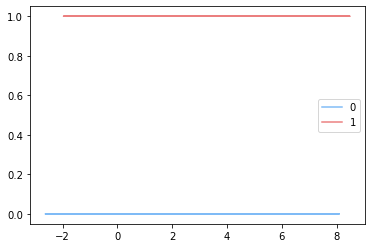

In [1030]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
projected = lda.fit_transform(X_train_feng, y_train)

cluster_colors = {0: '#0078ef', 1: '#d80000'}

for g in np.unique(y_train):
    idx = np.where(y_train == g)
    plt.plot(projected[idx], len(projected[idx]) * [g], 
            alpha=0.5, color=cluster_colors[g], label = g)

plt.legend()
plt.show()

#### Insight:

The seperation between 0 and 1 has too much overlaps, which is not good.

## 7.2 Non-linear methods (Manifold learning)

Techniques from high-dimensionality statistics can also be used for dimensionality reduction, it is often for the purposes of data visualization..

The projection is designed to both create a low-dimensional representation of the dataset whilst best preserving the salient structure or relationships in the data.

### Kernal PCA (training on down-sampling data as using full dataset will run of memory)

The intuition behind Kernel PCA is that the data is first run through a kernel function and temporarily projects them into a new higher-dimensional feature space where the classes become linearly separable. Then the algorithm uses the normal PCA to project the data back onto a lower-dimensional space. 

In this way, Kernel PCA transform non-linear data into a lower-dimensional space of data which can be used with linear classifiers.

In [97]:
X_train_feng = pd.read_pickle('data/X_train_feng')
y_train = pd.read_pickle('data/y_train')
X_test_feng = pd.read_pickle('data/X_test_feng')
y_test = pd.read_pickle('data/y_test')

# Class count
count_class_0, count_class_1 = y_train.value_counts()

# Divide by class
f_class_0 = X_train_feng.loc[y_train[y_train == 0].index, :].sample(count_class_1, random_state=1)
f_class_1 = X_train_feng.loc[y_train[y_train == 1].index, :]


X_train_down = pd.concat([f_class_0, f_class_1], axis=0)

print('Random under-sampling:')
print(X_train_down.shape)

y_train_down = y_train.loc[X_train_down.index]
y_train_down.value_counts()

Random under-sampling:
(18626, 53)


0    9313
1    9313
Name: isFraud, dtype: int64

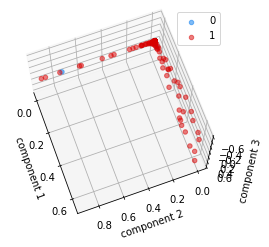

In [98]:
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d

kpca = KernelPCA(n_components = 3, kernel='rbf', 
                 gamma=15, random_state=42)
kpca_train = kpca.fit_transform(X_train_down) 

cluster_colors = {0: '#0078ef', 1: '#d80000'}

ax = plt.axes(projection='3d')

for g in np.unique(y_train_down):
    idx = np.where(y_train_down == g)
    ax.scatter(kpca_train[idx, 0], kpca_train[idx, 1], kpca_train[idx, 2],
            alpha=0.5, color=cluster_colors[g], label = g)

ax.view_init(azim=200, elev=250)
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')
plt.legend()
plt.show()

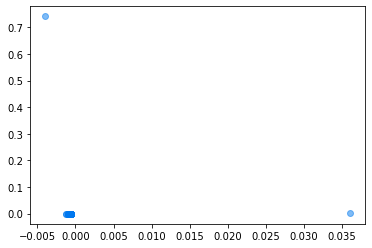

In [99]:
idx = np.where(y_train_down == 0)
plt.scatter(kpca_train[idx, 0], kpca_train[idx, 1],
        alpha=0.5, color=cluster_colors[0], label = 0)

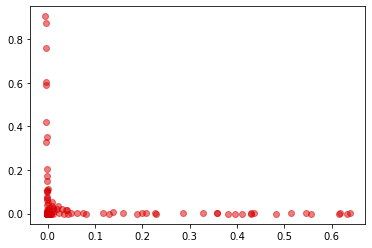

In [100]:
idx = np.where(y_train_down == 1)
plt.scatter(kpca_train[idx, 0], kpca_train[idx, 1],
            alpha=0.5, color=cluster_colors[1], label = 1)

### Multidimensional Scaling (MDS) (run out of memory)

MDA is another non-linear dimensionality reduction technique that tries to preserve the distances between instances while reducing the dimensionality of non-linear data. 

In [ ]:
# from sklearn.manifold import MDS
# from mpl_toolkits import mplot3d

# model = MDS(n_components=2, random_state=1)
# out = model.fit(X_train_feng).embedding_
# plt.scatter(out[:, 0], out[:, 1])
# plt.axis('equal')


# ax = plt.axes(projection='3d')
# ax.scatter3D(out[:, 0], out[:, 1], out[:, 2],
#              **colorize)
# ax.view_init(azim=70, elev=50)

### Kohonen Self-Organizing Map (SOM) (run out of memory)

This method performs non-linear dimensionality reduction through Isometric mapping. It is an extension of MDS or Kernel PCA. It connects each instance by calculating the curved or geodesic distance to its nearest neighbours and reduces dimensionality. 

In [4]:
# from sklearn.manifold import Isomap

# isomap = Isomap(n_neighbors=5, n_components=2, 
#                 eigen_solver='auto')
# projected = isomap.fit_transform(X_train_feng)

# cluster_colors = {0: '#0078ef', 1: '#d80000'}

# for g in np.unique(y_train):
#     idx = np.where(y_train == g)
#     plt.scatter(projected[idx, 0], projected[idx, 1], 
#             alpha=0.5, color=cluster_colors[g], label = g)

# plt.xlabel('component 1')
# plt.ylabel('component 2')
# plt.legend()
# plt.show()

### T-SNE

In [205]:
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA

# pca = PCA(n_components=3)
# projected = pca.fit_transform(X_train_feng)
# projected = TSNE(n_components=2).fit_transform(projected)

# cluster_colors = {0: '#0078ef', 1: '#d80000'}

# for g in np.unique(y_train):
#     idx = np.where(y_train == g)
#     plt.scatter(projected[idx, 0], projected[idx, 1], 
#             alpha=0.5, color=cluster_colors[g], label = g)

# plt.legend()
# plt.show()

# 8. Model Training & Result Evaluation & Feature Importance Visualisation

## data after feature engineering

In [101]:
X_train_feng = pd.read_pickle('data/X_train_feng')
y_train = pd.read_pickle('data/y_train')
X_test_feng = pd.read_pickle('data/X_test_feng')
y_test = pd.read_pickle('data/y_test')

best_params : {'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}


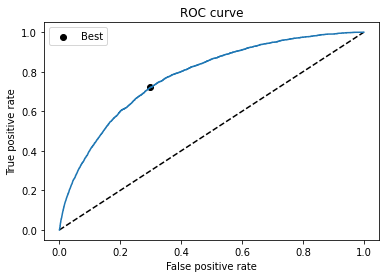

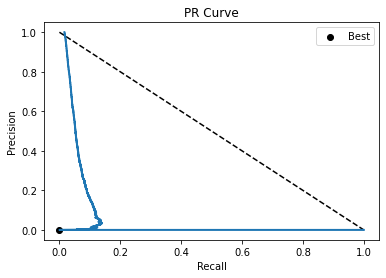

Best threshold:  0.49094564184563444
        pred_0  pred_1
true_0  131241   62246
true_1     794    2310
{'best_model': Pipeline(steps=[('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=10000))]), 'roc_auc': 0.7776364667191206, 'pr_auc': 0.06019164515737151, 'accuracy': 0.6793342523309815, 'recall': 0.7442010309278351, 'precision': 0.03578288617634302, 'fscore': 0.06828258941767662}


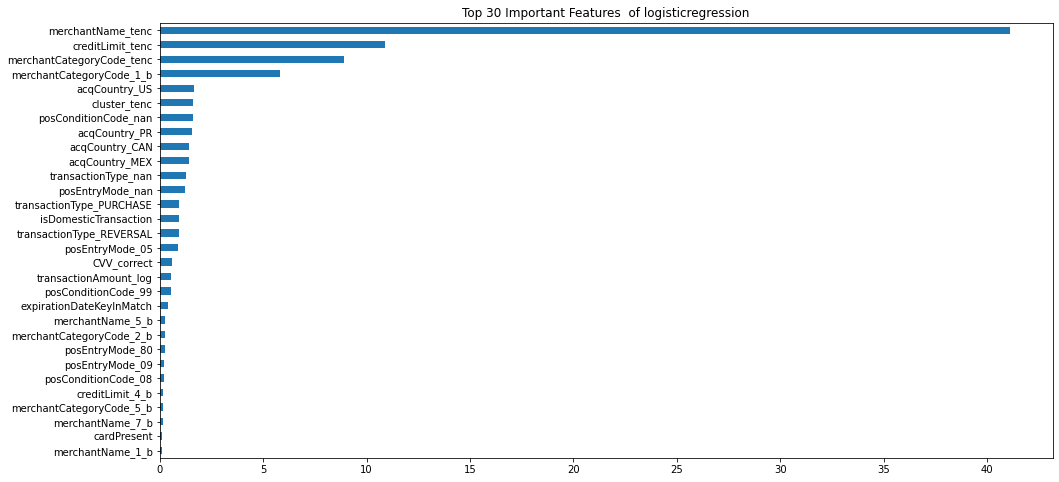

best_params : {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 55}


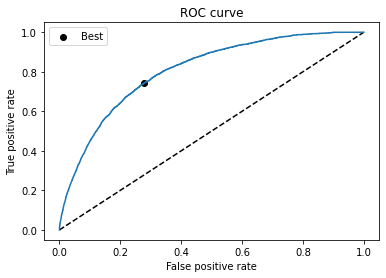

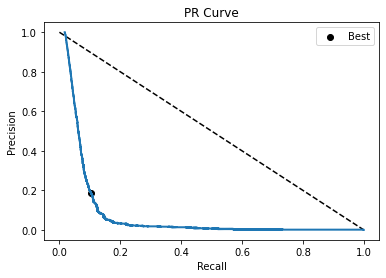

Best threshold:  0.4377820911014905
        pred_0  pred_1
true_0  139505   53982
true_1     793    2311
{'best_model': Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=55, random_state=2021))]), 'roc_auc': 0.8057651762773269, 'pr_auc': 0.07752723954123637, 'accuracy': 0.7213758513868895, 'recall': 0.7445231958762887, 'precision': 0.04105306165953138, 'fscore': 0.07781537788103776}


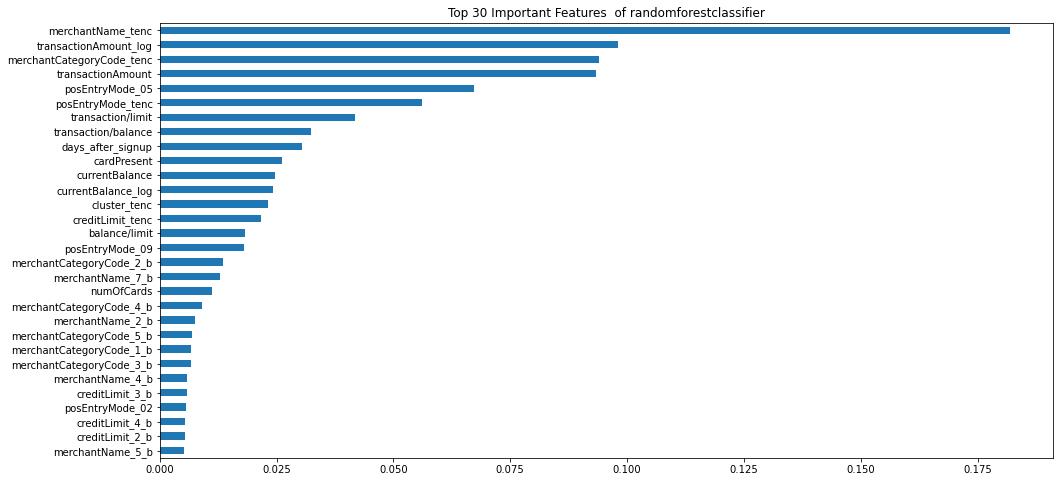

best_params : {'lgbmclassifier__class_weight': 'balanced', 'lgbmclassifier__max_depth': 30, 'lgbmclassifier__n_estimators': 55}


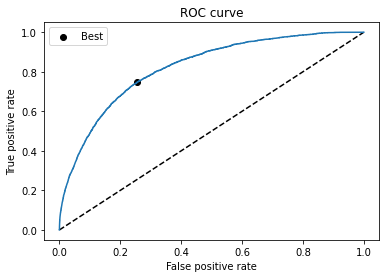

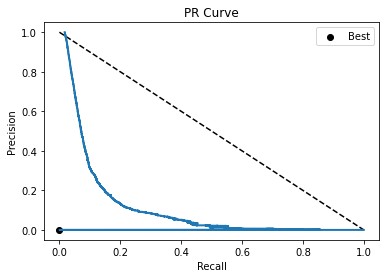

Best threshold:  0.496591028823548
        pred_0  pred_1
true_0  143932   49555
true_1     780    2324
{'best_model': Pipeline(steps=[('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', max_depth=30,
                                n_estimators=55, random_state=2021))]), 'roc_auc': 0.8212733574124882, 'pr_auc': 0.1117618823570632, 'accuracy': 0.743960812041243, 'recall': 0.7487113402061856, 'precision': 0.04479654580851597, 'fscore': 0.08453521997708383}


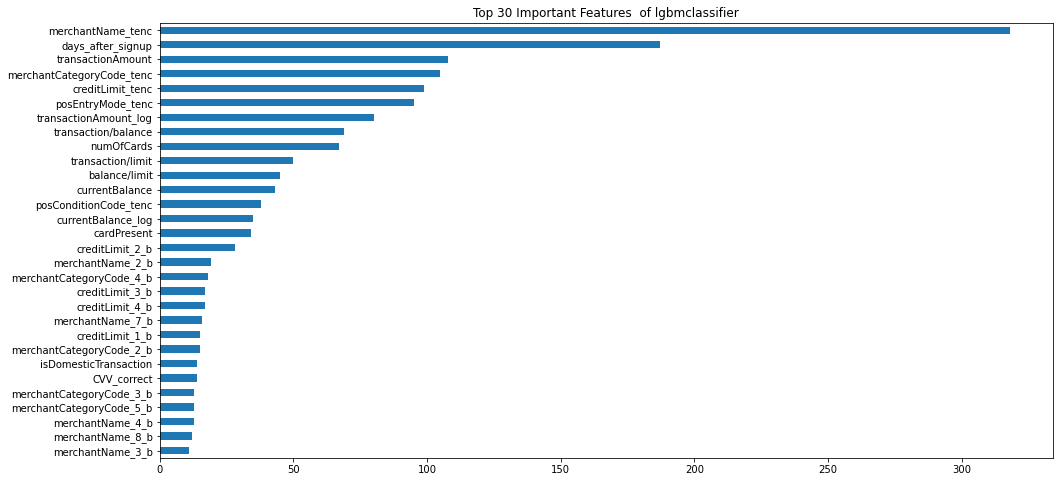

In [102]:
classifiers = [
    LogisticRegression(max_iter=10000),
    RandomForestClassifier(random_state=2021),
    LGBMClassifier(random_state=2021)

]

classifier_names = [
    'logisticregression', 'randomforestclassifier', 'lgbmclassifier'
]

classifier_param_grid = [
            {'logisticregression__penalty':['l2'], 'logisticregression__class_weight':[None, 'balanced']},
            {'randomforestclassifier__n_estimators': [55], 'randomforestclassifier__max_depth':[10, 15, 30], 'randomforestclassifier__class_weight':[None, 'balanced']},
            {'lgbmclassifier__n_estimators': [55], 'lgbmclassifier__max_depth':[10, 15, 30], 'lgbmclassifier__class_weight':[None, 'balanced']}
]

for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    pipeline = Pipeline([          
            (model_name, model)
    ])
    
    result = GridSearchCV_work(pipeline, X_train_feng, y_train, X_test_feng, y_test, model_param_grid, score = 'recall')
    
    scores = result['best_model'].named_steps[model_name].coef_ if model_name == 'logisticregression' else result['best_model'].named_steps[model_name].feature_importances_
    
    print(result)
    
    df_feature_score(model_name, X_train_feng.columns, scores)
    
    print("========================")
    

### Performance Summary:

using class_weight:

| Model                            | Recall   | Precision | F1 Score  |
| -------------------------------- | -------- | --------- | --------- |
| Weighted Logistic Regression     | 0.744    | 0.036     | 0.068     |
| Random Forest                    | 0.745    | 0.041     | 0.079     |
| LightGBM                         | 0.749    | 0.045     | 0.085     |


## adding PCA features

In [103]:
X_train_feng_pca = X_train_feng.copy()
X_test_feng_pca = X_test_feng.copy()

X_train_feng_pca['pca_1'] = X_train_pca.iloc[:,0]
X_train_feng_pca['pca_2'] = X_train_pca.iloc[:,1]
X_train_feng_pca['pca_3'] = X_train_pca.iloc[:,2]

X_test_feng_pca['pca_1'] = X_test_pca.iloc[:,0]
X_test_feng_pca['pca_2'] = X_test_pca.iloc[:,1]
X_test_feng_pca['pca_3'] = X_test_pca.iloc[:,2]

X_train_feng_pca.to_pickle('data/X_train_feng_pca')
X_test_feng_pca.to_pickle('data/X_test_feng_pca')

In [104]:
X_train_feng_pca = pd.read_pickle('data/X_train_feng_pca')
y_train = pd.read_pickle('data/y_train')
X_test_feng_pca = pd.read_pickle('data/X_test_feng_pca')
y_test = pd.read_pickle('data/y_test')

best_params : {'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}


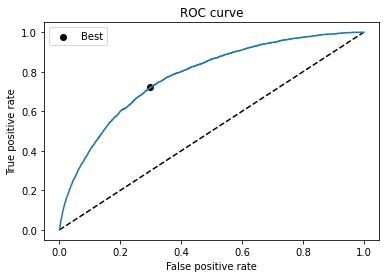

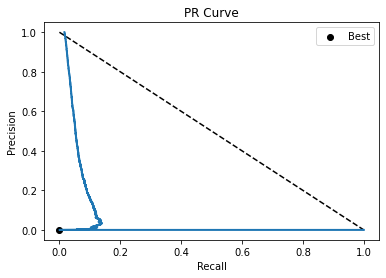

Best threshold:  0.49029769251865146
        pred_0  pred_1
true_0  131062   62425
true_1     791    2313
{'best_model': Pipeline(steps=[('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=10000))]), 'roc_auc': 0.7776180096731504, 'pr_auc': 0.06023196959280954, 'accuracy': 0.6784389926293676, 'recall': 0.7451675257731959, 'precision': 0.03572862924402978, 'fscore': 0.06818784823560627}


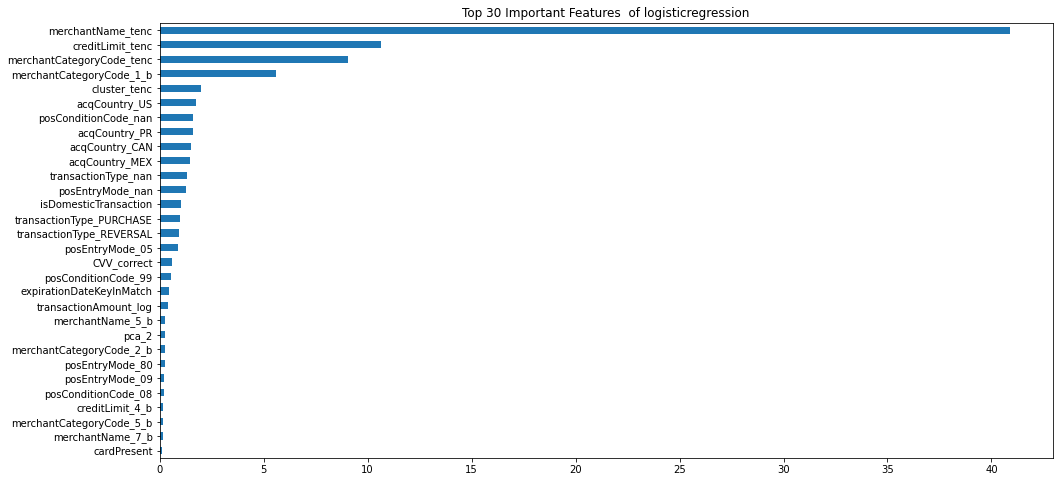

best_params : {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 55}


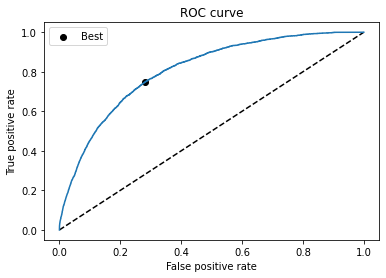

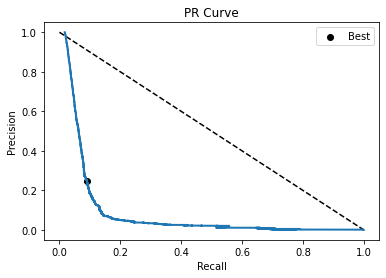

Best threshold:  0.42790450670219543
        pred_0  pred_1
true_0  137465   56022
true_1     754    2350
{'best_model': Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=55, random_state=2021))]), 'roc_auc': 0.8066092968285411, 'pr_auc': 0.08480615278089051, 'accuracy': 0.7111973589838803, 'recall': 0.7570876288659794, 'precision': 0.04025902830124032, 'fscore': 0.07645259938837921}


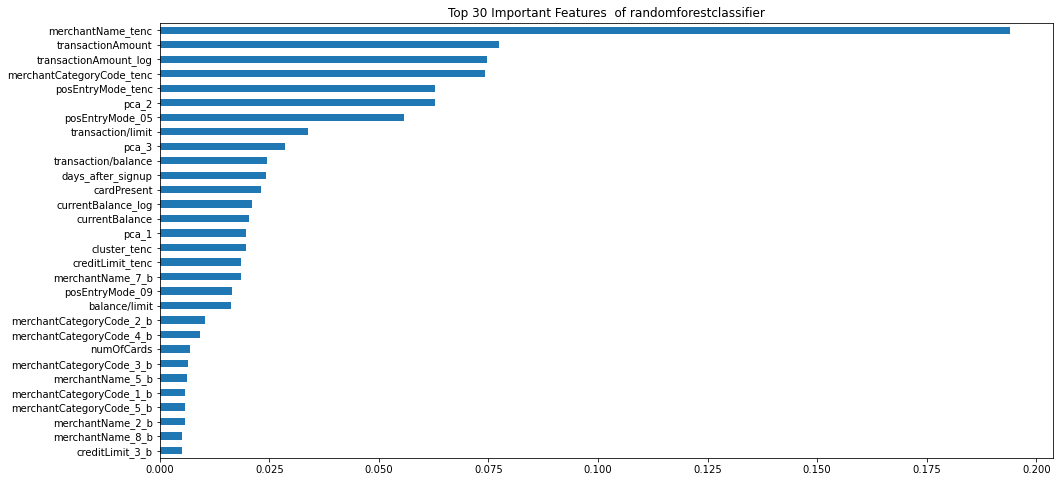

best_params : {'lgbmclassifier__class_weight': 'balanced', 'lgbmclassifier__max_depth': 15, 'lgbmclassifier__n_estimators': 55}


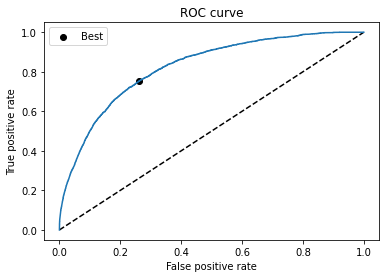

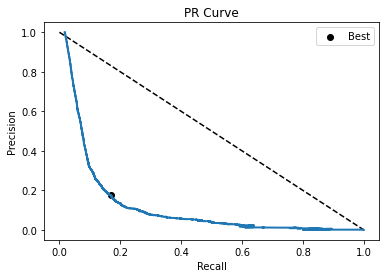

Best threshold:  0.4841228104462554
        pred_0  pred_1
true_0  141441   52046
true_1     742    2362
{'best_model': Pipeline(steps=[('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', max_depth=15,
                                n_estimators=55, random_state=2021))]), 'roc_auc': 0.8232627872012926, 'pr_auc': 0.11877554848832686, 'accuracy': 0.7314831299499978, 'recall': 0.7609536082474226, 'precision': 0.04341273342155565, 'fscore': 0.08213937960773404}


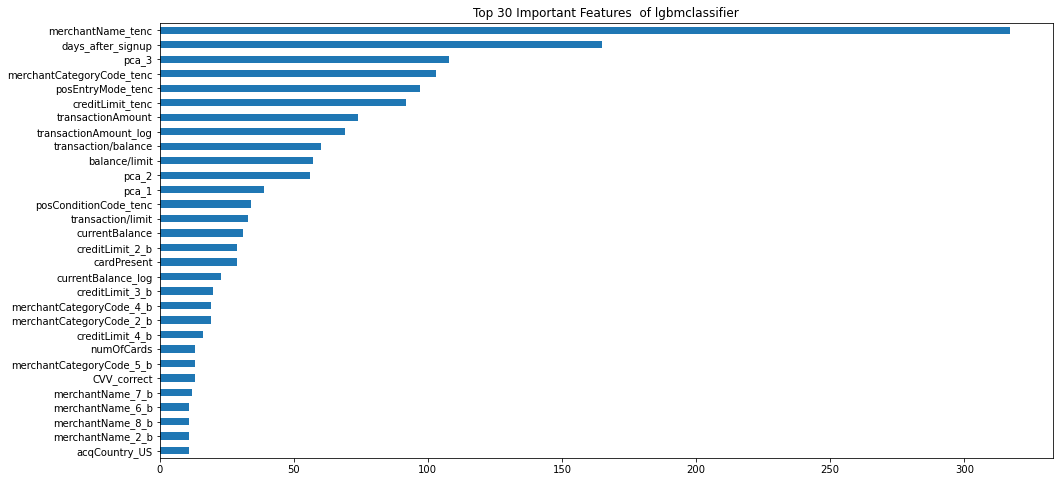

In [105]:
classifiers = [
    LogisticRegression(max_iter=10000),
    RandomForestClassifier(random_state=2021),
    LGBMClassifier(random_state=2021)
]

classifier_names = [
    'logisticregression', 'randomforestclassifier', 'lgbmclassifier'
]

classifier_param_grid = [
            {'logisticregression__penalty':['l2'], 'logisticregression__class_weight':[None, 'balanced']},
            {'randomforestclassifier__n_estimators': [55], 'randomforestclassifier__max_depth':[10, 15, 30], 'randomforestclassifier__class_weight':[None, 'balanced']},
            {'lgbmclassifier__n_estimators': [55], 'lgbmclassifier__max_depth':[10, 15, 30], 'lgbmclassifier__class_weight':[None, 'balanced']}
]

for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    pipeline = Pipeline([          
            (model_name, model)
    ])
    
    result = GridSearchCV_work(pipeline, X_train_feng_pca, y_train, X_test_feng_pca, y_test, model_param_grid, score = 'recall')
    
    scores = result['best_model'].named_steps[model_name].coef_ if model_name == 'logisticregression' else result['best_model'].named_steps[model_name].feature_importances_
    
    print(result)
    
    df_feature_score(model_name, X_train_feng_pca.columns, scores)
    
    print("========================")
    

### Performance Summary:

using full engineered features + extracted components from PCA:

| Model                            | Recall   | Precision | F1 Score  |
| -------------------------------- | -------- | --------- | --------- |
| Weighted Logistic Regression     | 0.745    | 0.036     | 0.068     |
| Random Forest                    | 0.757    | 0.040     | 0.076     |
| LightGBM                         | 0.761    | 0.043     | 0.082     |


## Down-sampling majority class

In [106]:
X_train_feng = pd.read_pickle('data/X_train_feng')
y_train = pd.read_pickle('data/y_train')
X_test_feng = pd.read_pickle('data/X_test_feng')
y_test = pd.read_pickle('data/y_test')

# Class count
count_class_0, count_class_1 = y_train.value_counts()

# Divide by class
f_class_0 = X_train_feng.loc[y_train[y_train == 0].index, :].sample(count_class_1, random_state=1)
f_class_1 = X_train_feng.loc[y_train[y_train == 1].index, :]


X_train_down = pd.concat([f_class_0, f_class_1], axis=0)

print('Random under-sampling:')
print(X_train_down.shape)

y_train_down = y_train.loc[X_train_down.index]
y_train_down.value_counts()

Random under-sampling:
(18626, 53)


0    9313
1    9313
Name: isFraud, dtype: int64

## Grid Search + Cross Validation

best_params : {'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}


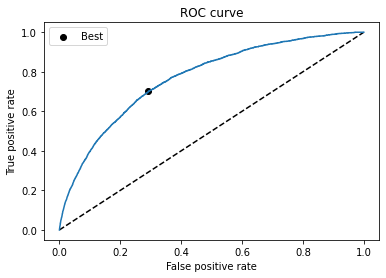

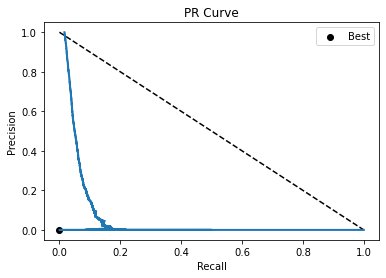

Best threshold:  0.5215988858867978
        pred_0  pred_1
true_0  136935   56552
true_1     929    2175
{'best_model': Pipeline(steps=[('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=10000))]), 'roc_auc': 0.7688879318272747, 'pr_auc': 0.059665835040142876, 'accuracy': 0.7076112334745741, 'recall': 0.7007087628865979, 'precision': 0.03703577570793672, 'fscore': 0.07035305914508903}


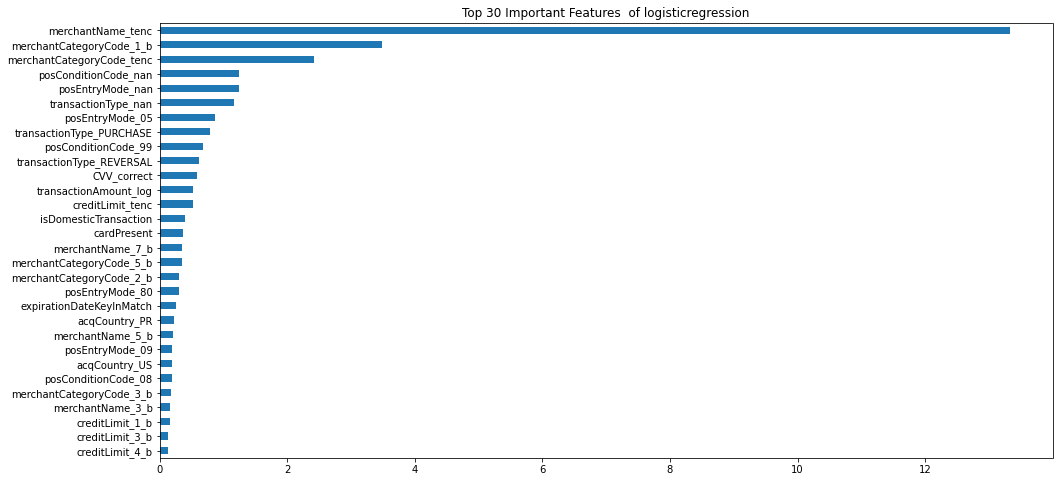

best_params : {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__n_estimators': 55}


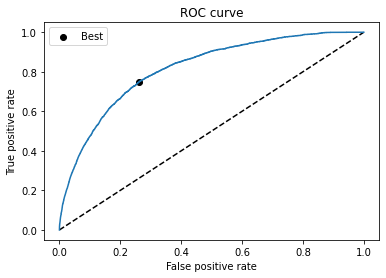

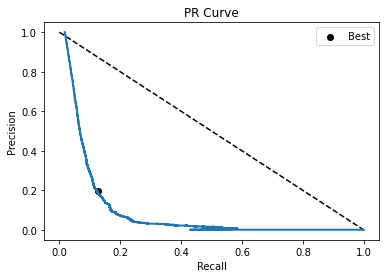

Best threshold:  0.4990825576530307
        pred_0  pred_1
true_0  142749   50738
true_1     776    2328
{'best_model': Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=15, n_estimators=55,
                                        random_state=2021))]), 'roc_auc': 0.8152382713556663, 'pr_auc': 0.09310302232425205, 'accuracy': 0.7379635893809992, 'recall': 0.75, 'precision': 0.04386989786303848, 'fscore': 0.08289122307281467}


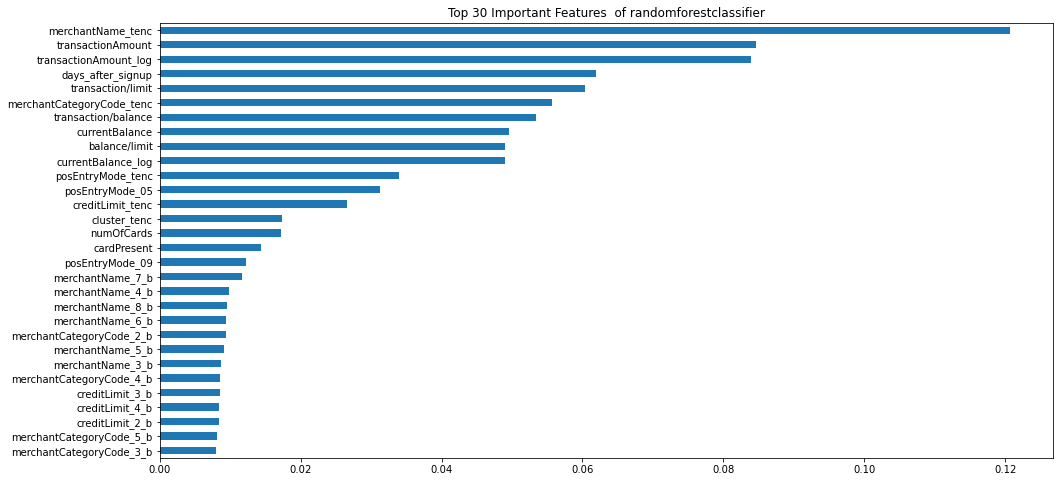

best_params : {'lgbmclassifier__class_weight': 'balanced', 'lgbmclassifier__max_depth': 15, 'lgbmclassifier__n_estimators': 55}


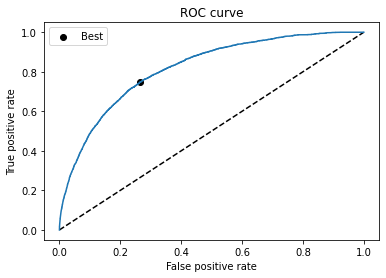

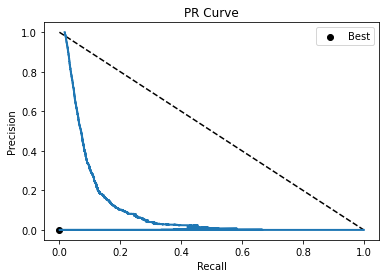

Best threshold:  0.4931362314599875
        pred_0  pred_1
true_0  140733   52754
true_1     758    2346
{'best_model': Pipeline(steps=[('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', max_depth=15,
                                n_estimators=55, random_state=2021))]), 'roc_auc': 0.8169801477845098, 'pr_auc': 0.09750698434737579, 'accuracy': 0.7278003570865401, 'recall': 0.7557989690721649, 'precision': 0.042577132486388385, 'fscore': 0.08061301628754038}


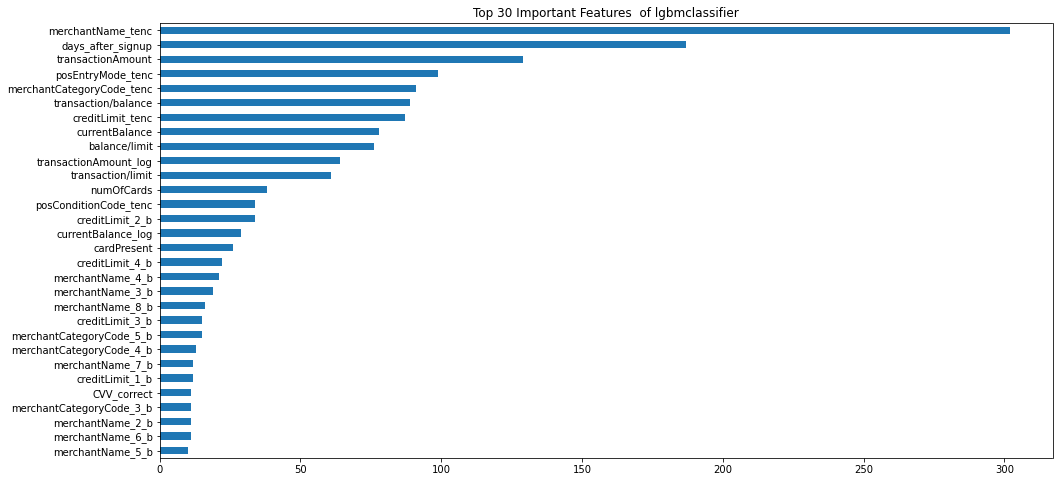

In [107]:
classifiers = [
    LogisticRegression(max_iter=10000),
    RandomForestClassifier(random_state=2021),
    LGBMClassifier(random_state=2021)

]

classifier_names = [
    'logisticregression', 'randomforestclassifier', 'lgbmclassifier'
]

classifier_param_grid = [
    {'logisticregression__penalty':['l2'], 'logisticregression__class_weight':[None, 'balanced']},
    {'randomforestclassifier__n_estimators': [55], 'randomforestclassifier__max_depth':[10, 15, 30], 'randomforestclassifier__class_weight':[None, 'balanced']},
    {'lgbmclassifier__n_estimators': [55], 'lgbmclassifier__max_depth':[10, 15, 30], 'lgbmclassifier__class_weight':[None, 'balanced']}
]

for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    pipeline = Pipeline([          
            (model_name, model)
    ])
    
    result = GridSearchCV_work(pipeline, X_train_down, y_train_down, X_test_feng, y_test, model_param_grid, score = 'recall')
    
    scores = result['best_model'].named_steps[model_name].coef_ if model_name == 'logisticregression' else result['best_model'].named_steps[model_name].feature_importances_
    
    print(result)
    
    df_feature_score(model_name, X_train_down.columns, scores)
    
    print("========================")
    

### Performance Summary:

using down-sampling:

| Model                            | Recall   | Precision | F1 Score  |
| -------------------------------- | -------- | --------- | --------- |
| Weighted Logistic Regression     | 0.701    | 0.037     | 0.070     |
| Random Forest                    | 0.750    | 0.044     | 0.083     |
| LightGBM                         | 0.756    | 0.043     | 0.081     |


## Down sampling with PCA feature

In [108]:
X_train_feng = pd.read_pickle('data/X_train_feng')
y_train = pd.read_pickle('data/y_train')
X_test_feng = pd.read_pickle('data/X_test_feng')
y_test = pd.read_pickle('data/y_test')

# Class count
count_class_0, count_class_1 = y_train.value_counts()

# Divide by class
f_class_0 = X_train_feng.loc[y_train[y_train == 0].index, :].sample(count_class_1, random_state=1)
f_class_1 = X_train_feng.loc[y_train[y_train == 1].index, :]


X_train_down = pd.concat([f_class_0, f_class_1], axis=0)

print('Random under-sampling:')
print(X_train_down.shape)

y_train_down = y_train.loc[X_train_down.index]
y_train_down.value_counts()

Random under-sampling:
(18626, 53)


0    9313
1    9313
Name: isFraud, dtype: int64

In [109]:
X_train_feng_pca = pd.read_pickle('data/X_train_feng_pca')
X_test_feng_pca = pd.read_pickle('data/X_test_feng_pca')

X_train_down_pca = X_train_feng_pca.loc[X_train_down.index]

best_params : {'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2'}


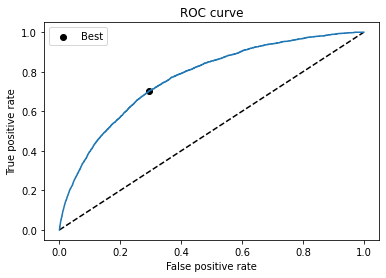

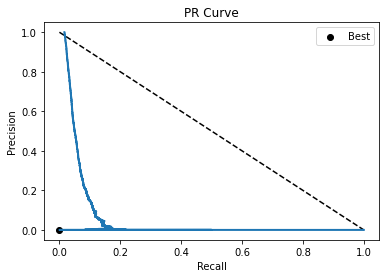

Best threshold:  0.5208056202456633
        pred_0  pred_1
true_0  136714   56773
true_1     926    2178
{'best_model': Pipeline(steps=[('logisticregression', LogisticRegression(max_iter=10000))]), 'roc_auc': 0.7688731179041357, 'pr_auc': 0.05966059632952428, 'accuracy': 0.7065023322532568, 'recall': 0.7016752577319587, 'precision': 0.036945938152024564, 'fscore': 0.07019579405366208}


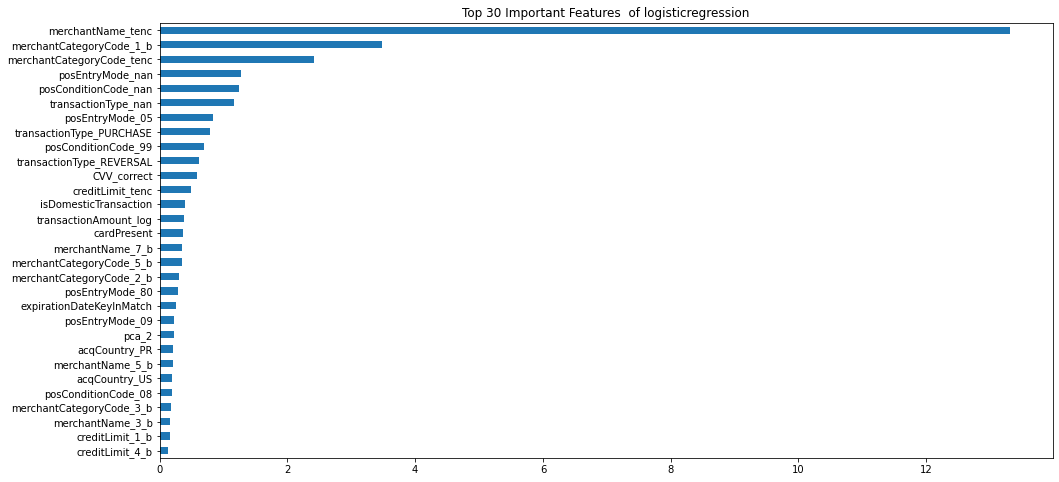

best_params : {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__n_estimators': 55}


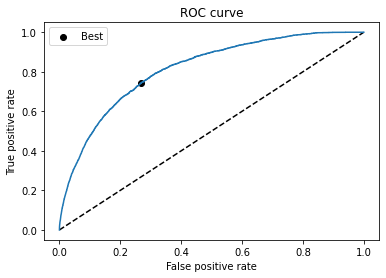

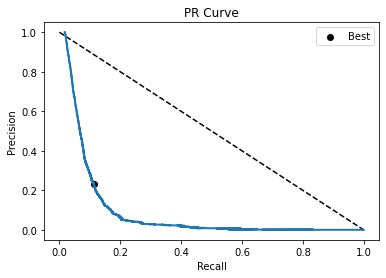

Best threshold:  0.46031646258023257
        pred_0  pred_1
true_0  132578   60909
true_1     644    2460
{'best_model': Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=15, n_estimators=55,
                                        random_state=2021))]), 'roc_auc': 0.8129196542826953, 'pr_auc': 0.09021910535027253, 'accuracy': 0.68689817946905, 'recall': 0.7925257731958762, 'precision': 0.038820243336647256, 'fscore': 0.07401501361455026}


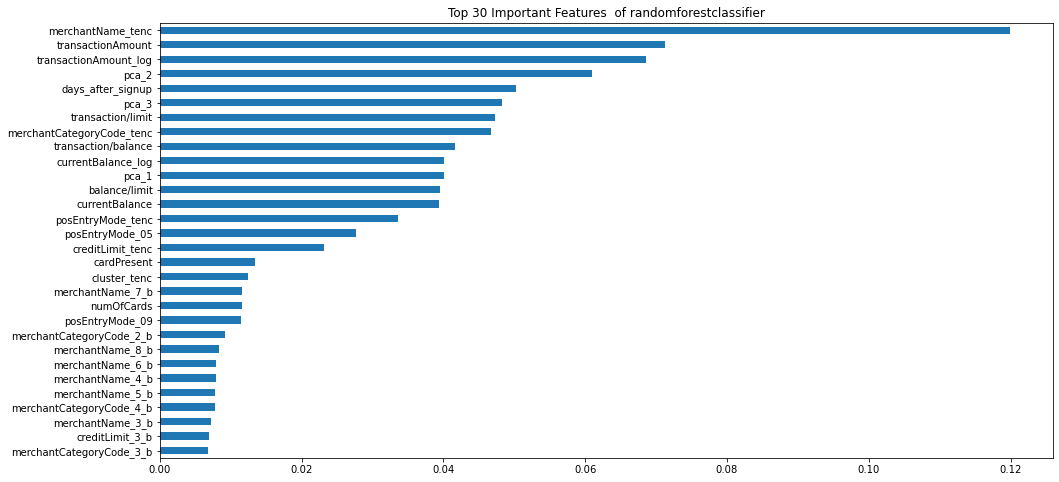

best_params : {'lgbmclassifier__class_weight': None, 'lgbmclassifier__max_depth': 15, 'lgbmclassifier__n_estimators': 55}


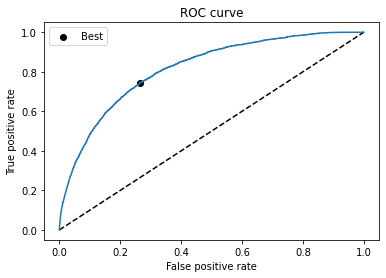

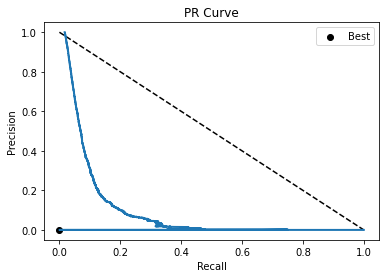

Best threshold:  0.5013384041295444
        pred_0  pred_1
true_0  142311   51176
true_1     795    2309
{'best_model': Pipeline(steps=[('lgbmclassifier',
                 LGBMClassifier(max_depth=15, n_estimators=55,
                                random_state=2021))]), 'roc_auc': 0.8152400471282893, 'pr_auc': 0.09496338655508718, 'accuracy': 0.7356389661785128, 'recall': 0.7438788659793815, 'precision': 0.04317098251846312, 'fscore': 0.08160596582374668}


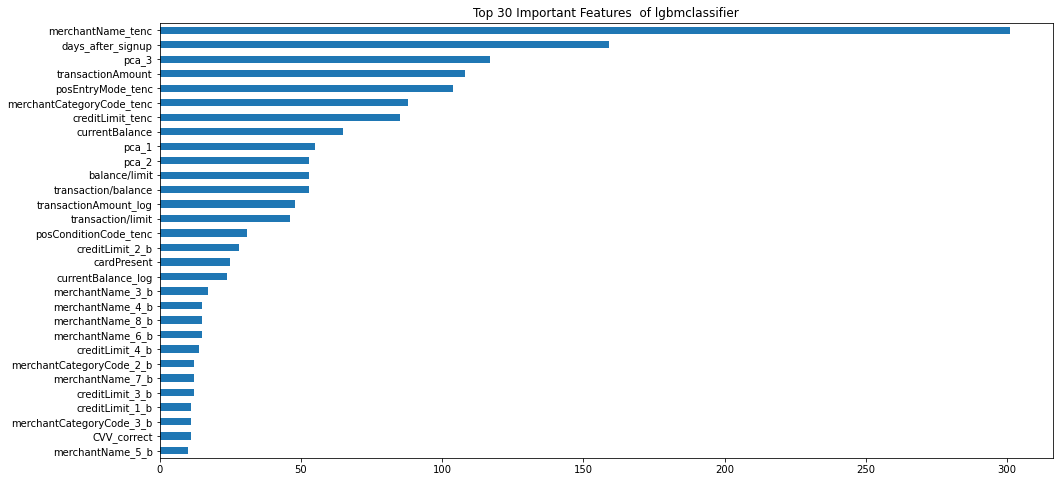

In [110]:
classifiers = [
    LogisticRegression(max_iter=10000),
    RandomForestClassifier(random_state=2021),
    LGBMClassifier(random_state=2021)

]

classifier_names = [
    'logisticregression', 'randomforestclassifier', 'lgbmclassifier'
]

classifier_param_grid = [
    {'logisticregression__penalty':['l2'], 'logisticregression__class_weight':[None, 'balanced']},
    {'randomforestclassifier__n_estimators': [55], 'randomforestclassifier__max_depth':[10, 15, 30], 'randomforestclassifier__class_weight':[None, 'balanced']},
    {'lgbmclassifier__n_estimators': [55], 'lgbmclassifier__max_depth':[10, 15, 30], 'lgbmclassifier__class_weight':[None, 'balanced']}
]

for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    pipeline = Pipeline([          
            (model_name, model)
    ])
    
    result = GridSearchCV_work(pipeline, X_train_down_pca, y_train_down, X_test_feng_pca, y_test, model_param_grid, score = 'recall')
    
    scores = result['best_model'].named_steps[model_name].coef_ if model_name == 'logisticregression' else result['best_model'].named_steps[model_name].feature_importances_
    
    print(result)
    
    df_feature_score(model_name, X_train_down_pca.columns, scores)
    
    print("========================")

### Performance Summary:

using down-sampling + PCA features:

| Model                            | Recall   | Precision | F1 Score  |
| -------------------------------- | -------- | --------- | --------- |
| Weighted Logistic Regression     | 0.702    | 0.037     | 0.070     |
| Random Forest                    | 0.793    | 0.039     | 0.074     |
| LightGBM                         | 0.744    | 0.043     | 0.082     |

using down-sampling:

| Model                            | Recall   | Precision | F1 Score  |
| -------------------------------- | -------- | --------- | --------- |
| Weighted Logistic Regression     | 0.701    | 0.037     | 0.070     |
| Random Forest                    | 0.750    | 0.044     | 0.083     |
| LightGBM                         | 0.756    | 0.043     | 0.081     |

using full data with manually engineered features + PCA features:

| Model                            | Recall   | Precision | F1 Score  |
| -------------------------------- | -------- | --------- | --------- |
| Weighted Logistic Regression     | 0.745    | 0.036     | 0.068     |
| Random Forest                    | 0.757    | 0.040     | 0.076     |
| LightGBM                         | 0.761    | 0.043     | 0.082     |

using full data with manually engineered features:

| Model                            | Recall   | Precision | F1 Score  |
| -------------------------------- | -------- | --------- | --------- |
| Weighted Logistic Regression     | 0.744    | 0.036     | 0.068     |
| Random Forest                    | 0.745    | 0.041     | 0.079     |
| LightGBM                         | 0.749    | 0.045     | 0.085     |

baseline:

| Model                            | Recall   | Precision | F1 Score  |
| -------------------------------- | -------- | --------- | --------- |
| Weighted Logistic Regression     | 0.714    | 0.035     | 0.067     |
| Random Forest                    | 0.681    | 0.039     | 0.075     |
| LightGBM                         | 0.799    | 0.038     | 0.074     |

### Thought:

1. It can tell that after doing feature engineering, except LightGBM shows a little decrease in recall, all models show an improved performance in recall, precision and f1 score. 

2. It shows adding PCA features can improve model's recall, but is harmful to the precisions, resulting a little decrease in f1score.

3. Down-sampling helps tree-based models improve their recall, and improves precision of random forest, but a bit decrease in precision for LightGBM.

#### Generally, the feature engineering helps improve above three models' performance from all aspects (recall, precision, f1score). 
#### The model giving the highest f1score is lightGBM using full data with manually engineered features.
#### But considering its running cost, random forest using down-sampling data is more fast in training and shows overall above-average performance with recall 0.75, precision 0.44 and and f1score 0.083.
#### Generally, the precision is hard to improve, all above models demonstrated consistently low precision and f1score.

# 9. Further Improvement - Model Stacking 

## Random Forest + XGBoost + LGBMClassifier -> Logistic Regression

In [135]:
X_train_feng = pd.read_pickle('data/X_train_feng')
y_train = pd.read_pickle('data/y_train')
X_test_feng = pd.read_pickle('data/X_test_feng')
y_test = pd.read_pickle('data/y_test')

# Class count
count_class_0, count_class_1 = y_train.value_counts()

# Divide by class
f_class_0 = X_train_feng.loc[y_train[y_train == 0].index, :].sample(count_class_1, random_state=1)
f_class_1 = X_train_feng.loc[y_train[y_train == 1].index, :]


X_train_down = pd.concat([f_class_0, f_class_1], axis=0)

print('Random under-sampling:')
print(X_train_down.shape)

y_train_down = y_train.loc[X_train_down.index]
y_train_down.value_counts()

Random under-sampling:
(18626, 53)


0    9313
1    9313
Name: isFraud, dtype: int64

### train & save: model A

In [143]:
a = RandomForestClassifier(random_state=2021, class_weight='balanced', max_depth=10, n_estimators=55)
a.fit(X_train_feng, y_train)

y_a = a.predict_proba(X_train_feng)[:,1]
y_a_test = a.predict_proba(X_test_feng)[:,1]
print(y_a)

[0.54601133 0.69618425 0.23680791 ... 0.17719024 0.45539608 0.19581559]


### train & save: model B

In [144]:
b = XGBClassifier(random_state=2021, use_label_encoder=False, eval_metric='logloss', max_depth=30, n_estimators=55)
b.fit(X_train_feng, y_train)

y_b = b.predict_proba(X_train_feng)[:,1]
y_b_test = b.predict_proba(X_test_feng)[:,1]
print(y_b)

[0.001517   0.01856098 0.00011539 ... 0.00057236 0.00230308 0.00045426]


### train & save: model C

In [145]:
c = LGBMClassifier(random_state=2021, max_depth=30, n_estimators=55)

c.fit(X_train_feng, y_train)

y_c = c.predict_proba(X_train_feng)[:,1]
y_c_test = c.predict_proba(X_test_feng)[:,1]
print(y_c)

[0.01553925 0.06214592 0.00718978 ... 0.00812791 0.01410846 0.00397302]


### concate outputs as new features

In [146]:
ys = pd.DataFrame(np.hstack((y_a.reshape(-1, 1), y_b.reshape(-1, 1), y_c.reshape(-1, 1))), columns=['y_a', 'y_b', 'y_c'])
ys_test = pd.DataFrame(np.hstack((y_a_test.reshape(-1, 1), y_b_test.reshape(-1, 1), y_c_test.reshape(-1, 1))), columns=['y_a', 'y_b', 'y_c'])

ys_test.head()

,y_a,y_b,y_c
0,0.468,0.008,0.016
1,0.718,0.011,0.049
2,0.324,0.000,0.006
3,0.249,0.000,0.004
4,0.216,0.000,0.007


### stacking model

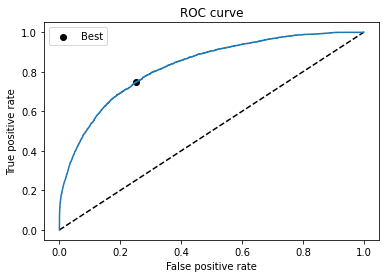

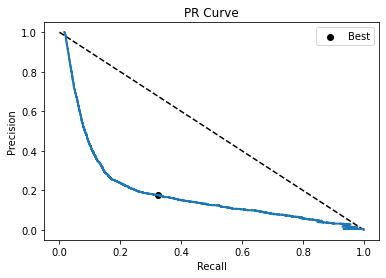

Best threshold:  0.00026259422259900547

fscore is: : 0.08177968995424435
roc_auc_score is: : 0.8291535619697725
pr_auc_score is: : 0.18931250729769333
accuracy_score is: : 0.7264269473170186
recall_score is: : 0.7715850515463918
precision_score is: : 0.04317804860460085
        pred_0  pred_1
true_0  140414   53073
true_1     709    2395


In [147]:
stacked_model = LogisticRegression(max_iter=10000, penalty='l2', class_weight='balanced')

stacked_model.fit(ys, y_train)

st_y_prob = stacked_model.predict_proba(ys_test)[:,1]
    
fpr, tpr, thresholds = roc_curve(y_test, st_y_prob)
plot_ROC_curve(fpr, tpr)


precisions, recalls, _ = precision_recall_curve(y_test, st_y_prob) 
plot_PR_curve(precisions, recalls)


ix = np.argmax(tpr - fpr) # this approach weighs recall and fpr equally
print('Best threshold: ', thresholds[ix])
print()

st_y = (st_y_prob >= thresholds[ix]).astype(int)

recall = recall_score(y_test, st_y)
precision = precision_score(y_test, st_y)
fscore = (2 * precision * recall) / (precision + recall)

print("%s: %r" % ("fscore is: ", fscore))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, st_y_prob)))
print("%s: %r" % ("pr_auc_score is: ", auc(recalls, precisions)))
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, st_y)))
print("%s: %r" % ("recall_score is: ", recall))
print("%s: %r" % ("precision_score is: ", precision))

cm = confusion_matrix(y_test, st_y)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

# 10. Further Improvement - Cascade Models

In [316]:
prob_to_ada_y = np.vectorize(lambda x, thresh: 1 if x >= thresh else -1)

def pred_given_threshold(model, X, y, threshold):
    y_prob = model.predict_proba(X)[:,1]

    print("threshold is: ", threshold)
    y_pred = prob_to_ada_y(y_prob, threshold) 
    
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)

    fscore = (2 * precision * recall) / (precision + recall)

    cm = confusion_matrix(y, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    print("precision: {:.3f}, recall: {:.3f}, fscore: {:.3f}".format(precision, recall, fscore))
    
    return y_pred

def pred_high_recall(model, X, y):
    y_prob = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(y, y_prob)
    ix = np.argmax(tpr - fpr)   
    print("threshold is: ", thresholds[ix])
    y_pred = prob_to_ada_y(y_prob, thresholds[ix])
    
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)

    fscore = (2 * precision * recall) / (precision + recall)

    cm = confusion_matrix(y, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    print("precision: {:.3f}, recall: {:.3f}, fscore: {:.3f}".format(precision, recall, fscore))
    
    return thresholds[ix], y_pred

def pred_high_precision(model, X, y):
    y_prob = model.predict_proba(X)[:,1]
   
    precisions, recalls, thresholds = precision_recall_curve(y, y_prob) 
    fscore = (2 * precisions * recalls) / (precisions + recalls)
    ix = np.argmax(fscore)
    print("threshold is: ", thresholds[ix])
    y_pred = prob_to_ada_y(y_prob, thresholds[ix]) 
    
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)

    fscore = (2 * precision * recall) / (precision + recall)

    cm = confusion_matrix(y, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    print("precision: {:.3f}, recall: {:.3f}, fscore: {:.3f}".format(precision, recall, fscore))
    
    return thresholds[ix], y_pred

def visualPred(df, X):
    pca = PCA()
    projected = pd.DataFrame(pca.fit_transform(X), index=X.index)

    cluster_colors = {0: '#0078ef', 1: '#d80000'}

    idx = df[(df["true"] == df["pred"])].index
    plt.scatter(projected.loc[idx, 0], projected.loc[idx, 1], 
            alpha=0.5, color='pink', label = 'correct')

    idx = df[(df["true"] != 1) & (df["pred"] == 1)].index
    plt.scatter(projected.loc[idx, 0], projected.loc[idx, 1], 
            alpha=0.5, color=cluster_colors[1], label = 'false positive')
    
    idx = df[(df["true"] == 1) & (df["pred"] != 1)].index
    plt.scatter(projected.loc[idx, 0], projected.loc[idx, 1], 
            alpha=0.5, color=cluster_colors[0], label = 'false negative')

    plt.legend()
    plt.show()

## Train 1st Random Forest -- focusing on achieving high recall

### initialise sample weights with equal weight: 1/n

In [315]:
X_train_feng = pd.read_pickle('data/X_train_feng')
y_train = pd.read_pickle('data/y_train')
X_test_feng = pd.read_pickle('data/X_test_feng')
y_test = pd.read_pickle('data/y_test')

In [318]:
y_train_ada = pd.Series(np.where(y_train == 0, -1, 1), index = y_train.index)
y_test_ada = pd.Series(np.where(y_test == 0, -1, 1), index = y_test.index)

training_count = X_train_feng.shape[0]
sample_weights = np.zeros(shape=(4, training_count))
sample_weights[0] = np.ones(shape=training_count)/training_count

### train on initial sample weights

In [368]:
model1 = RandomForestClassifier(random_state=2021, class_weight='balanced', max_depth=15, n_estimators=55) #10 100
# LGBMClassifier(random_state=2021, max_depth=15, n_estimators=15)
# model = sklearn.svm.SVC(C=0.001, kernel='rbf', class_weight='balanced')

model1.fit(X_train_feng, y_train_ada, sample_weight=sample_weights[0])

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=55,
                       random_state=2021)

In [369]:
thresh1, y_pred1 = pred_high_recall(model1, X_train_feng, y_train_ada)

threshold is:  0.40623400082311567
        pred_0  pred_1
true_0  485420   95039
true_1     244    9069
precision: 0.087, recall: 0.974, fscore: 0.160


In [370]:
pred_given_threshold(model1, X_test_feng, y_test_ada, thresh1)

threshold is:  0.40623400082311567
        pred_0  pred_1
true_0  161230   32257
true_1    1205    1899
precision: 0.056, recall: 0.612, fscore: 0.102


array([-1,  1, -1, ..., -1, -1, -1])

### calculate model's total error (sum of sample weight of misclassified samples)

In [371]:
err1 = sample_weights[0][(y_pred1 != y_train_ada.values)].sum()
err1

0.16155904315566008

### determine model's performance (alpha)

In [372]:
alpha1 = 0.5*np.log((1 - err1) / err1)
alpha1

0.8233367477131405

### update sample weights (for following cascade model training samples)

1. assign less weight to correct predictions and more weight to incorrect prediction
2. normalise weight

In [373]:
# assign less weight to correct prediction and more weight to wrong prediction
new_sample_weights = sample_weights[0] * np.exp(-alpha1 * y_train_ada.values * y_pred1)

# normalise weight
new_sample_weights /= new_sample_weights.sum()

sample_weights[1] = new_sample_weights

sample_weights[1] 

array([1.01114484e-06, 5.24752579e-06, 1.01114484e-06, ...,
       1.01114484e-06, 1.01114484e-06, 1.01114484e-06])

### visualise prediction

In [374]:
df1 = pd.DataFrame(index = X_train_feng.index)
df1['true'] = y_train_ada
df1['pred'] = y_pred1
df1.head()

,true,pred
247233,-1,-1
733168,-1,1
103031,-1,-1
576728,-1,-1
703102,-1,-1


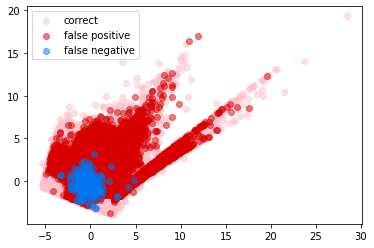

In [375]:
visualPred(df1, X_train_feng)

## Train 2nd Random Forest -- focusing on achieving high precision 

Giving more attention on those wrong predictions from 1st model (borrow the idea from AdaBoost). The difference is that AdaBoost uses homogeneous model and don't support fine-tuning on each base model.

## Train Four Random Forest cascadingly

In [443]:
y_train_ada = pd.Series(np.where(y_train == 0, -1, 1), index = y_train.index)
y_test_ada = pd.Series(np.where(y_test == 0, -1, 1), index = y_test.index)

training_count = X_train_feng.shape[0]
sample_weights = np.zeros(shape=(4, training_count))
sample_weights[0] = np.ones(shape=training_count)/training_count

models = [RandomForestClassifier(random_state=2021, class_weight='balanced', max_depth=15, n_estimators=55),
          RandomForestClassifier(random_state=2021, class_weight='balanced', max_depth=15, n_estimators=55),
          RandomForestClassifier(random_state=2021, class_weight='balanced', max_depth=15, n_estimators=55),
          RandomForestClassifier(random_state=2021, class_weight='balanced', max_depth=15, n_estimators=55)]

In [444]:
def cascadeTraining(models, sample_weights, X_train, y_train_ada, X_test, y_test_ada):
    preds = []
    alphas = []
    
    for idx, model in enumerate(models):
        print("model {}".format(idx))
        
        model.fit(X_train, y_train_ada, sample_weight=sample_weights[idx])
        if idx % 2 == 0:
            thresh, y_pred = pred_high_recall(model, X_train, y_train_ada)
        else:
            thresh, y_pred = pred_high_precision(model, X_train, y_train_ada)
        
        print("====test====")
        pred = pred_given_threshold(model, X_test, y_test_ada, thresh)
        preds.append(pred)
        
        err = sample_weights[idx][(y_pred != y_train_ada.values)].sum()
        print("error: ", err)
        
        alpha = 0.5*np.log((1 - err) / err)
        alphas.append(alpha)
        print("alpha: ", alpha)
    
        new_sample_weights = sample_weights[idx] * np.exp(-alpha * y_train_ada.values * y_pred)
        new_sample_weights /= new_sample_weights.sum()
        
        if idx != len(models)-1:
            sample_weights[idx+1] = new_sample_weights
            print("sample_weights: ", sample_weights[idx+1])
        
    return alphas, preds

In [445]:
alphas, preds = cascadeTraining(models, sample_weights, X_train_feng, y_train_ada, X_test_feng, y_test_ada)

model 0
threshold is:  0.40623400082311567
        pred_0  pred_1
true_0  485420   95039
true_1     244    9069
precision: 0.087, recall: 0.974, fscore: 0.160
====test====
threshold is:  0.40623400082311567
        pred_0  pred_1
true_0  161230   32257
true_1    1205    1899
precision: 0.056, recall: 0.612, fscore: 0.102
error:  0.16155904315566008
alpha:  0.8233367477131405
sample_weights:  [1.01114484e-06 5.24752579e-06 1.01114484e-06 ... 1.01114484e-06
 1.01114484e-06 1.01114484e-06]
model 1
threshold is:  0.4522893302514252
        pred_0  pred_1
true_0  574914    5545
true_1    4227    5086
precision: 0.478, recall: 0.546, fscore: 0.510
====test====
threshold is:  0.4522893302514252
        pred_0  pred_1
true_0  191288    2199
true_1    2492     612
precision: 0.218, recall: 0.197, fscore: 0.207
error:  0.031939742984142136
alpha:  1.705721619200697
sample_weights:  [5.22253047e-07 2.71033014e-06 5.22253047e-07 ... 5.22253047e-07
 5.22253047e-07 5.22253047e-07]
model 2
threshold 

## Final prediction -- apply cascade models on test set & take weighted vote

In [446]:
k = 3
# equivalent to: y_final = np.sign(alphas[0] * preds[0] + alphas[1] * preds[1] + ... alphas[k] * preds[k])
y_final = np.sign(np.dot(np.transpose(preds[:k]), np.array(alphas[:k])))

df_t = pd.DataFrame(index = X_test_feng_pca.index)
df_t['true'] = y_test_ada
df_t['pred'] = y_final

recall = recall_score(df_t['true'], df_t['pred'])
precision = precision_score(df_t['true'], df_t['pred'])

fscore = (2 * precision * recall) / (precision + recall)
    
cm = confusion_matrix(df_t['true'], df_t['pred'])
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print("precision: {:.3f}, recall: {:.3f}, fscore: {:.3f}".format(precision, recall, fscore))

        pred_0  pred_1
true_0  191288    2199
true_1    2492     612
precision: 0.218, recall: 0.197, fscore: 0.207


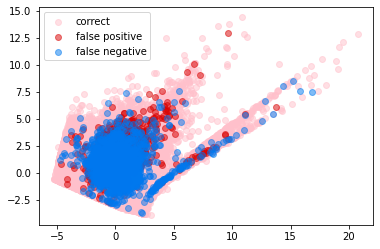

In [447]:
visualPred(df_t, X_test_feng)

### Thought:

Cascading models improves the precision significantly, but at some cost of recall decreasing. However, in imbalance dataset, it is hard to achieve both high precision and recall, there always is a trade-off between those two metrics. 

Generally speaking, this approach resolves the low precision issue observed in all previous models.

### Performance Summary:

using full data with manually engineered features:

| Model                            | Recall   | Precision | F1 Score  |
| -------------------------------- | -------- | --------- | --------- |
| Weighted Logistic Regression     | 0.744    | 0.036     | 0.068     |
| Random Forest                    | 0.745    | 0.041     | 0.079     |
| LightGBM                         | 0.749    | 0.045     | 0.085     |
| Stacking                         | 0.772    | 0.043     | 0.082     |
| Cascading                        | 0.197    | 0.218     | 0.207     |

From summary table it can tell that:

1. By further stacking models, the meta-learner can achieve the highest recall;
2. By cascading models, the final output can significantly improve the precision and achieve the highest f1score. 

### Experiment: 

### if the model is trained with high precision initially, its performance is not as good as it could be as second model in model cascade.

In [319]:
model_t = RandomForestClassifier(random_state=2021, class_weight='balanced', max_depth=15, n_estimators=55) #10 100
# LGBMClassifier(random_state=2021, max_depth=15, n_estimators=15)
# model = sklearn.svm.SVC(C=0.001, kernel='rbf', class_weight='balanced')

model_t.fit(X_train_feng, y_train_ada)

thresh, y_pred = pred_high_precision(model_t, X_train_feng, y_train_ada)

threshold is:  0.7360967892250054
        pred_0  pred_1
true_0  568243   12216
true_1    5983    3330
precision: 0.214, recall: 0.358, fscore: 0.268


In [321]:
pred_given_threshold(model_t, X_test_feng, y_test_ada, thresh)

threshold is:  0.7360967892250054
        pred_0  pred_1
true_0  189259    4228
true_1    2518     586
precision: 0.122, recall: 0.189, fscore: 0.148


array([-1, -1, -1, ..., -1, -1, -1])

### Thought:

The above experiment trains the model for high precision, it shows that the model only achieves f1score = 0.148, however the final f1score could be achieving at 0.207 after adding more weight on the wrong predictin from first model.

# 11. Upsampling  - SMOTE

In [73]:
# pip install -U imbalanced-learn

In [116]:
# import imblearn
# from imblearn.over_sampling import SMOTE

# smt = SMOTE(random_state =12) 

# X_train_sm,y_train_sm = smt.fit_resample(X_train, y_train)
# unique, counts = np.unique(y_train_sm, return_counts=True)
# print(np.asarray((unique, counts)).T)